## Table of Contents
* [Introduction](#section-one)
* [Goals](#section-two)
* [Dataset](#section-three)
* [Explore the Dataset](#section-four)
* [Train the Models](#section-five)
* [Discussion](#section-six)

<a id="section-one"></a>
## Introduction
League of Legends **(LoL)** is an immensely popular multiplayer online battle arena game, with over 100 million monthly active users worldwide.  It hosts progressional competitions throughout the year and had 43 million viewers in the 2016 World Championships alone.  For context, that's more than the 30.8 million viewers that watched Game 7 of the 2016 NBA finals!  Published by Riot Games, LOL is clearly fun and addictive once you get started.  For those who haven't, here's a quick overview of the game itself.

10 players are divided into 2 teams (blue or red) in the main LoL game (there are 3 modes).  The objective for each team is to destroy the opposing teams "Nexus".  Think of the Nexus as the main building in a base camp.  Destroy the enemy Nexus and your team wins the game.  Protect yours or your team loses the game.  Simple enough.  However, the collaboration often required between teammates to advance on the enemy Nexus, while defending its own, is wonderfully complex.   

Let's dive right in.

<a id="section-two"></a>
## Goals
Teams must efficiently choose between the various objectives to try to increase their chance of winning. Deciding which objectives are most meaningful or impactful can be a challenge, especially taking time to secure a certain objective can result in losing a different objective to the enemy team. 

We present two goals for our analysis: 

1. We will attempt to train a classification model to predict the winner of a game based on the objectives taken by each team at the 30 minute mark. 

2. Determine which objectives are most impactful to the game outcome, specifically, which objectives significantly increase the chances of winning the game, and which objectives, when taken by the enemy team, significantly decrease the chances of winning the game.

![Map](https://gamehag.com/img/uploaded/Lci2gbpdudF4PppLvaGAEizERRhVdi.jpg)

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import statsmodels.api as sm
import math
%matplotlib inline

from pandas import DataFrame
from subprocess import check_output
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from pandas import DataFrame
import matplotlib.gridspec as gridspec


### Data info

In [3]:
df_columns = pd.read_csv('./data/raw_data/_columns.csv',sep=',')
df_raw = pd.read_csv('./data/raw_data/LeagueofLegends.csv',sep=',')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620 entries, 0 to 7619
Data columns (total 57 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   League            7620 non-null   object
 1   Year              7620 non-null   int64 
 2   Season            7620 non-null   object
 3   Type              7620 non-null   object
 4   blueTeamTag       7582 non-null   object
 5   bResult           7620 non-null   int64 
 6   rResult           7620 non-null   int64 
 7   redTeamTag        7583 non-null   object
 8   gamelength        7620 non-null   int64 
 9   golddiff          7620 non-null   object
 10  goldblue          7620 non-null   object
 11  bKills            7620 non-null   object
 12  bTowers           7620 non-null   object
 13  bInhibs           7620 non-null   object
 14  bDragons          7620 non-null   object
 15  bBarons           7620 non-null   object
 16  bHeralds          7620 non-null   object
 17  goldred       

In [4]:
# What the data looks like
df_raw.head(1)

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,redMiddleChamp,goldredMiddle,redADC,redADCChamp,goldredADC,redSupport,redSupportChamp,goldredSupport,redBans,Address
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,Fizz,"[475, 475, 552, 842, 1178, 1378, 1635, 1949, 2...",Sneaky,Sivir,"[475, 475, 532, 762, 1097, 1469, 1726, 2112, 2...",LemonNation,Thresh,"[515, 515, 577, 722, 911, 1042, 1194, 1370, 14...","['Tristana', 'Leblanc', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...


## Data Observations  

* Wow that's a lot of columns.


* Notice how the **golddiff** column, along with several others, have lists in place of singular values.  I'm not typically accustomed to dealing with data in this format so it looks like we'll get some solid practice translating it.    


* It would also likely be easier to add another column that tells if 'red' or 'blue' won the game in a 'win' column.  That information is already present in 'bResult' and 'rResult', but the 'win' column we'll create will fit more cleanly into visualizations later on.  


* Note that it's often best practice (from my perspective) to first start exploring the dependent variable (what you'll be predicting for (wins)) first.  But we're going to detour from that and take a look at **gamelength** first.  Here's why:
    * 'df_raw.info()' reveals that gamelength is an integer data type so we can immediately plot away
    * Gamelength seems like a variable that will be helpful in building context for the rest of the data

In [5]:
# Copying df_raw to keep it unmodified and adding some columns to df
df = df_raw.copy(deep=True)
df['win_team'] = np.where(df['bResult']==1, 'blue', 'red')
df[['win_team', 'bResult', 'rResult']].head()

,win_team,bResult,rResult
0,blue,1,0
1,red,0,1
2,blue,1,0
3,red,0,1
4,blue,1,0


## Game Length

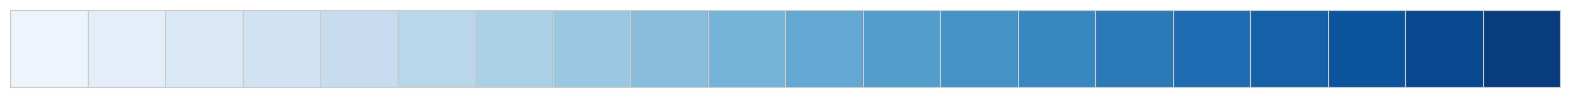

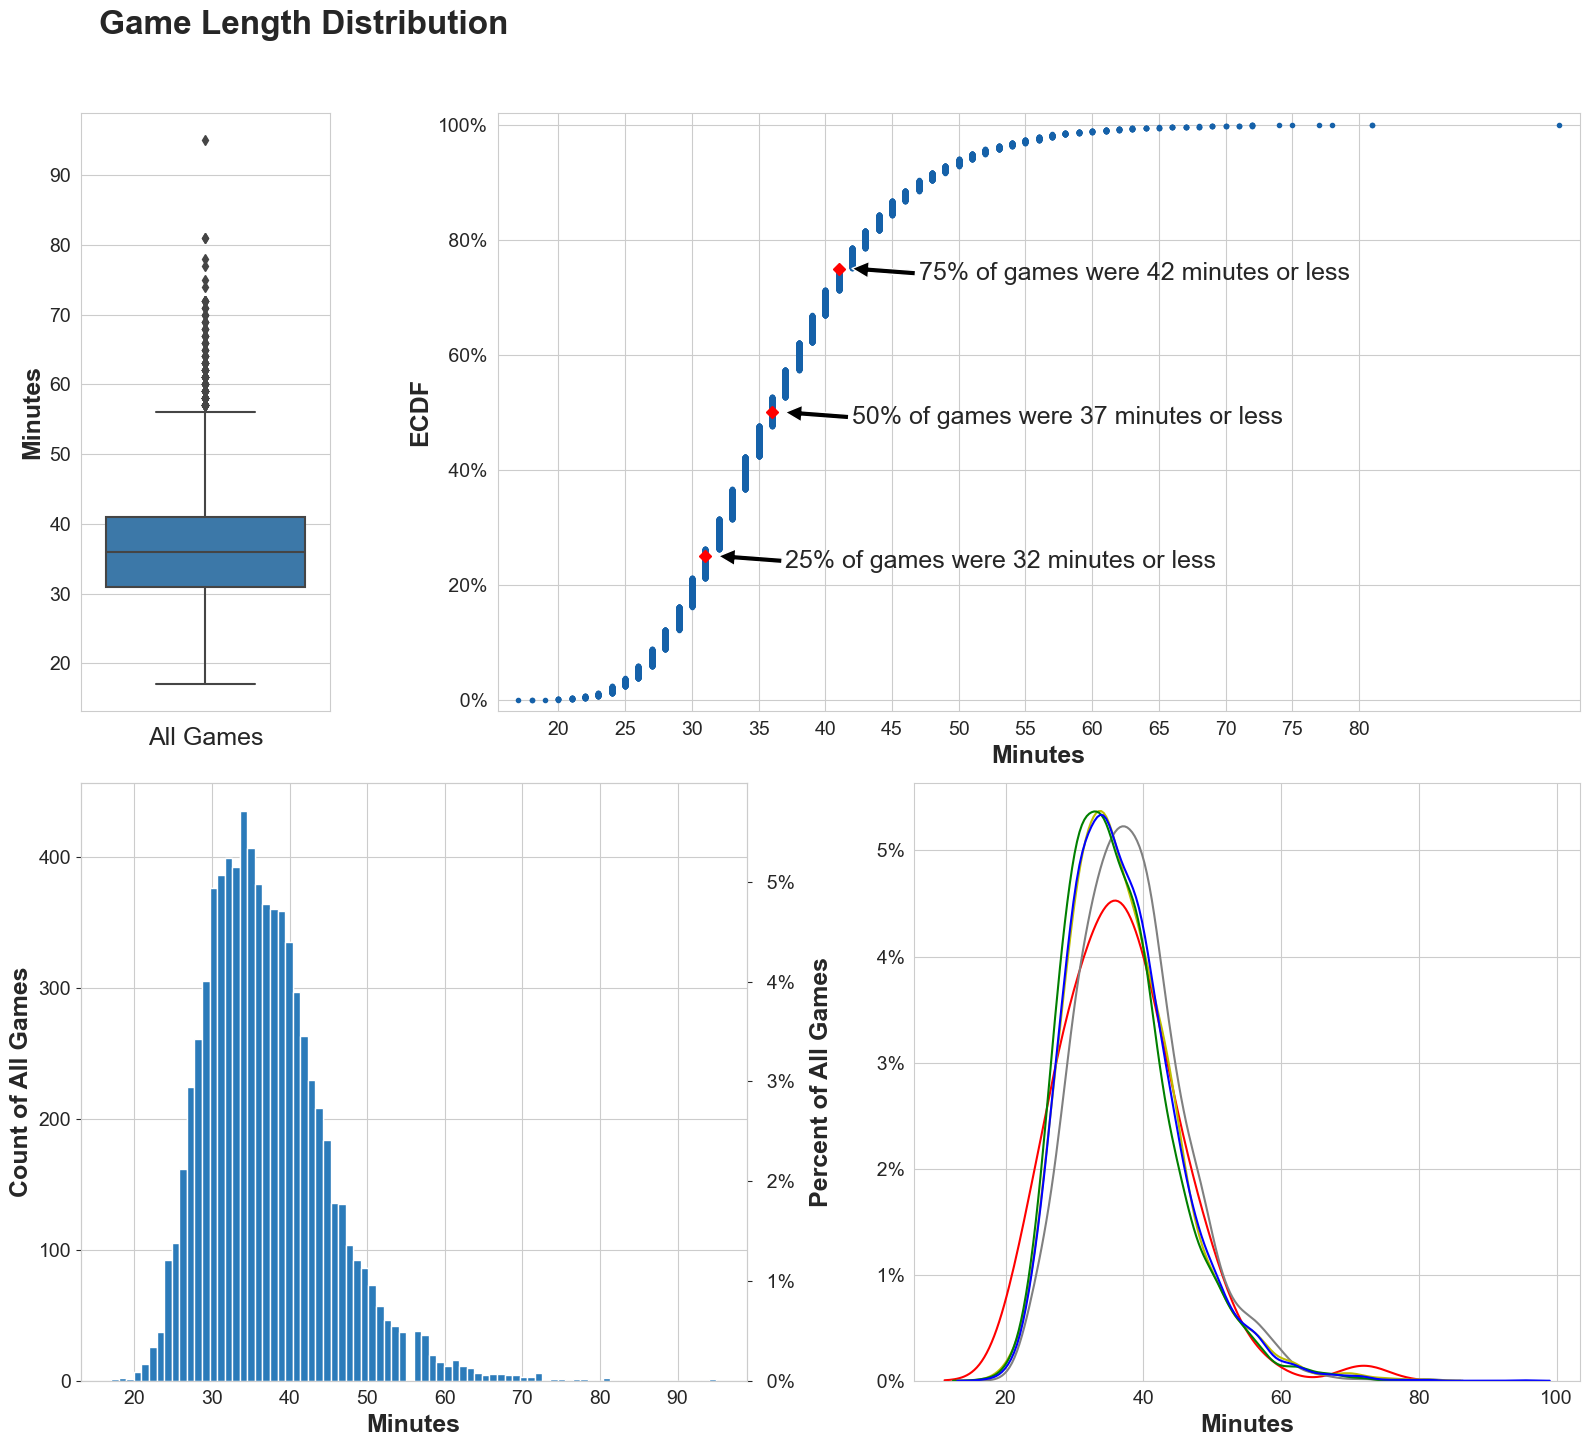

In [6]:
# Setstyle options
sns.set_style('whitegrid')
sns.palplot(sns.color_palette('Blues', 20))
colors = sns.color_palette('Blues', 20)

# Create Figure
fig, ax = plt.subplots(2,4, figsize=(16,14))
fig.suptitle('Game Length Distribution', x=0.065, y=1.03, fontsize=24, fontweight='bold', 
             horizontalalignment='left')
fig.subplots_adjust(top=0.9)

percentiles = np.array([25, 50, 75])
ptiles_gl = np.percentile(df['gamelength'], percentiles)

# Create Subplots

# 1 Box and Whisker
p1 = plt.subplot2grid((2,4), (0,0), colspan=1)
sns.boxplot(y=df['gamelength'], color=colors[14])
# Swarm plot adds no value here, ignore below
# sns.swarmplot(y=df['gamelength'], color=colors[2])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('All Games', fontsize=18)
plt.ylabel('Minutes', fontsize = 18, fontweight = 'bold')

# 2 ECDF Plot
p2 = plt.subplot2grid((2,4), (0,1), colspan=3)
x = np.sort(df['gamelength'])
y = np.arange(1, len(x) + 1) / len(x)
plt.plot(x,y, marker='.', linestyle='none', color=colors[16])
plt.plot(ptiles_gl, percentiles/100, marker='D', color='red', linestyle='none')

# 2 ECDF Formatting (a lot)
yvals = p2.get_yticks()
p2.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])
plt.yticks(fontsize=14)
plt.xticks(np.arange(0, 85, 5), fontsize=14)
plt.xlabel('Minutes', fontsize=18, fontweight = 'bold')
plt.ylabel('ECDF', fontsize=18, fontweight='bold')
plt.margins(0.02)

plt.annotate('25% of games were 32 minutes or less', xy=(32, .25), xytext=(37, .23), fontsize=18, 
             arrowprops=dict(facecolor='black'))
plt.annotate('50% of games were 37 minutes or less', xy=(37, .5), xytext=(42, .48), 
             fontsize=18, arrowprops=dict(facecolor='black'))
plt.annotate('75% of games were 42 minutes or less', xy=(42, .75), xytext=(47, .73), fontsize=18, 
             arrowprops=dict(facecolor='black'))

# 3 Histogram Count
p3 = plt.subplot2grid((2,4), (1,0), colspan=2)
plt.hist(x='gamelength', bins=80, data=df, color=colors[14])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Minutes', fontweight = 'bold', fontsize = 18)
plt.ylabel('Count of All Games', fontsize=18, fontweight='bold')

# 3 Histogram Percentage - Second Y Axis for Percent (To DO - align Y2 ytick values to Y1 ytick lines)
weights = np.ones_like(df['gamelength']) / len(df['gamelength'])
p3 = plt.twinx()
plt.hist(x='gamelength', bins=80, weights= weights, data=df, color=colors[14])
yvals = p3.get_yticks()
p3.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
p3.grid(b=False)

# 4 Distribution Plot across Years
p4 = plt.subplot2grid((2,4), (1,2), colspan=2)
sns.distplot((df['gamelength'][df['Year']==2014]), hist=False, color='r', label='2014')
sns.distplot((df['gamelength'][df['Year']==2015]), hist=False, color='grey', label='2015')
sns.distplot((df['gamelength'][df['Year']==2016]), hist=False, color='y', label='2016')
sns.distplot((df['gamelength'][df['Year']==2017]), hist=False, color='g', label='2017')
sns.distplot((df['gamelength']), hist=False, color='b', label='All Years')

# Formatting
yvals = p4.get_yticks()
p4.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylabel('Percent of All Games\n', fontsize=18, fontweight='bold')
plt.xlabel('Minutes', fontsize = 18, fontweight = 'bold')

# Show everything
plt.tight_layout()
plt.show()

_________________________

The above figure takes a look at the distributions of Game Length from a few different approaches:

*  **Box and Whisker Plot** (top left).  This plot shows a lot of similar detail as the ECDF (top right) but I feel is slightly more intuitive.  The blue shaded part is known as the IQR (inter quartile range) and each horizontal line of the box represents the 25th, 50th, and 75th percentiles (bottom to top).  So if we applied an ascending sort to the data in game length and chopped that data in half, the data point at the half would be equivalent to the median or 50th percentile.  Chop the bottom half of the original data split again and that half is the 25th percentile.  Do the same with the top and you have the 75th percentile.  We get a little added context here in seeing the outliers (little dots) a little more blatantly than the ECDF provides so that's helpful.

*  **ECDF** (Empirical Cumulative Distribution Function (top left)).  Here's an insightful way of seeing what percent of the variable data is at or below a particular value.  As the annotations in this first plot show, 25% of the **gamelength** data is at 32 minutes or less.  Move up and to the right of the ECDF and you'll continue to see the Y% of gamelength data that is at or below X minutes.  
    * What's worth mentioning from a holistic ECDF view is that a vertically straight line would suggest little variability in the variable (where all game lengths are the same).  
    * Conversely, a horizontal ECDF would indicate a lot of variability within the data set.  **This ECDF seems to be relatively standard and lie somewhere in between.**  And we can widen our perspective from the remaining plots.

* **Histogram** (bottom left).  The traditional histogram count is on the left y axis and the percentage of all games is on the right y axis.  This immediately shows the most freqent minute value of all competitve LOL games played.  We can see that it is slightly skewed right (tail of the data is longer on the right).  Also another angle on the outlier game lengths around the 60 minute mark.


* **Distribution Plot** (bottom right).  This plot is breaking the shape of the histogram on the left down by **Year** although we include the 'All Years' shape for context / verification in blue.  It looks like the game minutes distributions have skewed a bit more right in 2016 and 2017, as the apex of distributions for 2014 an 2015 are a bit further right than 2016 and 2017.  Several reasons could be attributed to the slight distribution shift.  It could be changes in game play strategy to in app purchase behaviors or sample size (2014 had far fewer games).  Nothing starkly different or worth really digging into at this point but maybe good to keep in mind for later model building and test intperetation.  Maybe.

# Wins (Dependent Variable)
As my ultimate goal is to see what attributes are suggestive of wins, let's now take a look at the distribution of blue wins vs red wins over time.

In [7]:
pvt_wins_y = df.pivot_table(index = 'Year', values = ['bResult', 'rResult'], aggfunc = np.sum,  
                                margins = False)
pvt_wins_y['b_net_wins'] = pvt_wins_y['bResult'] - pvt_wins_y['rResult']
pvt_wins_y['b_win_pcnt'] = pvt_wins_y['bResult'] / (pvt_wins_y['bResult'] + pvt_wins_y['rResult'])
pvt_wins_y['b_pcnt_diff'] = pvt_wins_y['b_win_pcnt'] -.5
pvt_wins_y

,bResult,rResult,b_net_wins,b_win_pcnt,b_pcnt_diff
Year,,,,,
2014,46,32,14,0.589744,0.089744
2015,818,678,140,0.546791,0.046791
2016,1317,1177,140,0.528067,0.028067
2017,1832,1479,353,0.553307,0.053307
2018,133,108,25,0.551867,0.051867


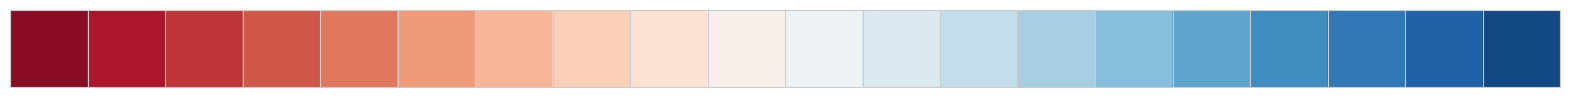

In [8]:
sns.palplot(sns.color_palette('RdBu', 20))

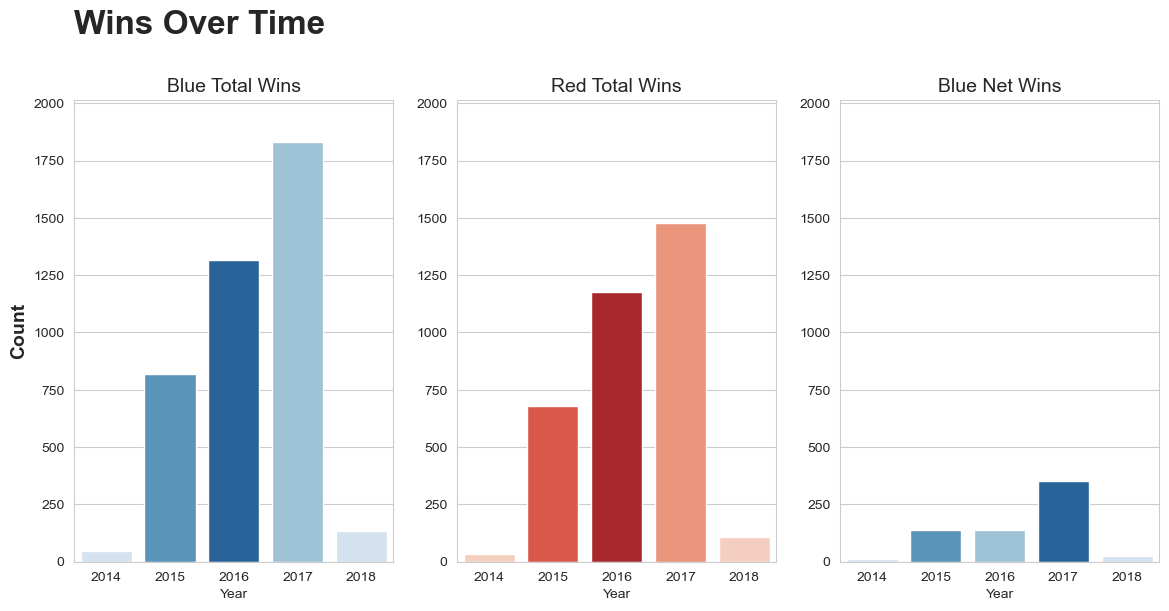

In [9]:
# Set plot styles and colors
blues = sns.color_palette('Blues', 4)
reds = sns.color_palette('Reds', 4)

# Control y 
y_max = 1.1 * max(max(pvt_wins_y['bResult']), max(pvt_wins_y['rResult']))

fig, axes = plt.subplots(1,3, figsize=(14,6))
fig.suptitle('Wins Over Time', x=0.125, y=1.03, fontsize=24, fontweight='bold', 
             horizontalalignment='left')

# Blue Total Wins Plot
plt.subplot(1,3,1)
sns.barplot(x=pvt_wins_y.index, y='bResult', data = pvt_wins_y, palette=[blues[0], blues[2], blues[3], blues[1]])
plt.title('Blue Total Wins', fontsize=14)
plt.ylim(0, y_max)
plt.ylabel('Count', fontsize = 14, fontweight = 'bold')

# Red Total Wins Plot
plt.subplot(1,3,2)
sns.barplot(x=pvt_wins_y.index, y='rResult', data = pvt_wins_y, palette=[reds[0], reds[2], reds[3], reds[1]])
plt.title('Red Total Wins', fontsize=14)
plt.ylim(0, y_max)
plt.ylabel('')

# Blue Net Wins Plot
plt.subplot(1,3,3)
sns.barplot(x=pvt_wins_y.index, y='b_net_wins', data = pvt_wins_y, palette=[blues[0], blues[2], blues[1], blues[3]])
plt.title('Blue Net Wins', fontsize=14)
plt.ylim(0, y_max)
plt.ylabel('')

plt.show()

**Looks like blue wins disproportionately more often than chance.**  We can clearly see this in the right most plot, "Blue Net Wins", which only shows positive valued bars (negative would indicate red net wins).  

There are a few theories on why this is, and Nicholas Ver Halen posted a fantastic kernel on the main LOL Kaggle page speaking to them.  With that aspect already explored, I'll only dive a bit deeper than what we see above and look at Blue vs Red wins from **League** and **Season** perspectives.  I'm still doing this across time, mainly because I'm always interested in how things are changing over time.

In [10]:
dct_leagues = {'NALCS':'NALCS', 'EULCS':'EULCS', 'LCK':'LCK', 'LMS':'LMS', 'CBLoL':'CBLoL', 'TCL':'TCL', 'OPL':'OPL', 'CLS':'CLS',
       'LLN':'LLN', 'LJL':'LJL', 'LCL':'LCL', 'WC':'WC', 'MSI':'MSI', 'IEM':'IEM', 'RR':'RR'}

# Map League Abbreviations
df['LA'] = df['League'].map(dct_leagues)
print(pd.unique(df['LA']))
df[['League', 'LA']].head()

['NALCS' 'EULCS' 'LCK' 'LMS' 'CBLoL' 'TCL' 'OPL' 'CLS' 'LLN' 'LJL' 'LCL'
 'WC' 'MSI' 'IEM' 'RR']


,League,LA
0,NALCS,NALCS
1,NALCS,NALCS
2,NALCS,NALCS
3,NALCS,NALCS
4,NALCS,NALCS


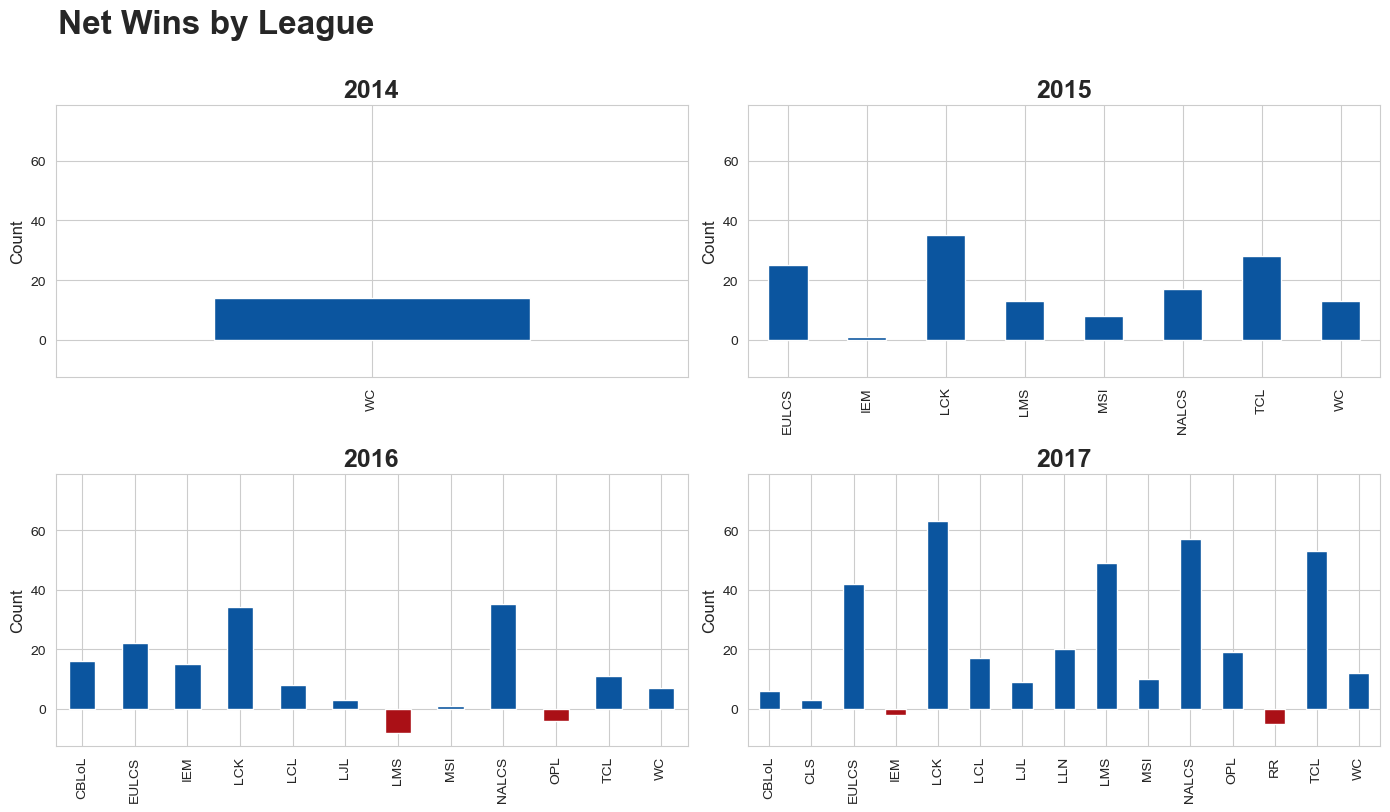

In [11]:
# Pivot by Year and League
pvt_net_wins_yl = df.pivot_table(index = ['Year', 'LA'], values = ['bResult', 'rResult'], aggfunc=np.sum)
pvt_net_wins_yl['b_net_wins'] = pvt_net_wins_yl['bResult'] - pvt_net_wins_yl['rResult']
pvt_net_wins_yl['positive'] = pvt_net_wins_yl['b_net_wins'] > 0

# Color Formatting
blues = sns.color_palette('Blues')
reds = sns.color_palette('Reds')

lst_years = pd.unique(pvt_net_wins_yl.index.get_level_values(0))
lst_x = [1, 2, 3, 4]

y_max = 1.25 * pvt_net_wins_yl['b_net_wins'].max()
y_min = 1.25 * pvt_net_wins_yl['b_net_wins'].min()

fig, ax = plt.subplots(2,2, figsize = (14,8))
fig.suptitle('Net Wins by League', x=0.045, y=1.01, fontsize=24, fontweight='bold', horizontalalignment='left')

for y, x in zip(lst_years, lst_x):
    # Filter pvt for year
    pvt_net_wins_yx = pvt_net_wins_yl[np.in1d(pvt_net_wins_yl.index.get_level_values(0), y)]
    pvt_net_wins_yx = pvt_net_wins_yx.reset_index(level=0, drop=True)
    
    p = plt.subplot(2,2,x)

    # Plot across Leagues
    pvt_net_wins_yx['b_net_wins'].plot(kind='bar', 
                                       color=pvt_net_wins_yx.positive.map({True:blues[5], 
                                                                           False:reds[5]}))
    
    # Format each plot
    plt.title(y, fontsize= 18, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Count', fontsize=12)
    plt.ylim(y_min, y_max)

plt.tight_layout()
fig.subplots_adjust(top=0.89)
plt.show()  

A few net wins for red in 2016 in the LMS league, and a sliver in 2017 in CBLOL.  Still, blue wins much more often than the coin flip likelihood you'd expect.

In [12]:
dct_seasons = {'Spring':'SPRS', 'Summer':'SUMS'}

# Map Seasons
df['SA'] = df['Season'].map(dct_seasons)
print(pd.unique(df['SA']))
df[['Season', 'SA']].head()

['SPRS' 'SUMS']


,Season,SA
0,Spring,SPRS
1,Spring,SPRS
2,Spring,SPRS
3,Spring,SPRS
4,Spring,SPRS


In [13]:
df.pivot_table(index = ['Year', 'SA'], values = ['bResult', 'rResult'], aggfunc=np.sum)

bResult  rResult
Year SA                    
2014 SUMS       46       32
2015 SPRS      361      298
     SUMS      457      380
2016 SPRS      574      499
     SUMS      743      678
2017 SPRS      859      680
     SUMS      973      799
2018 SPRS      133      108

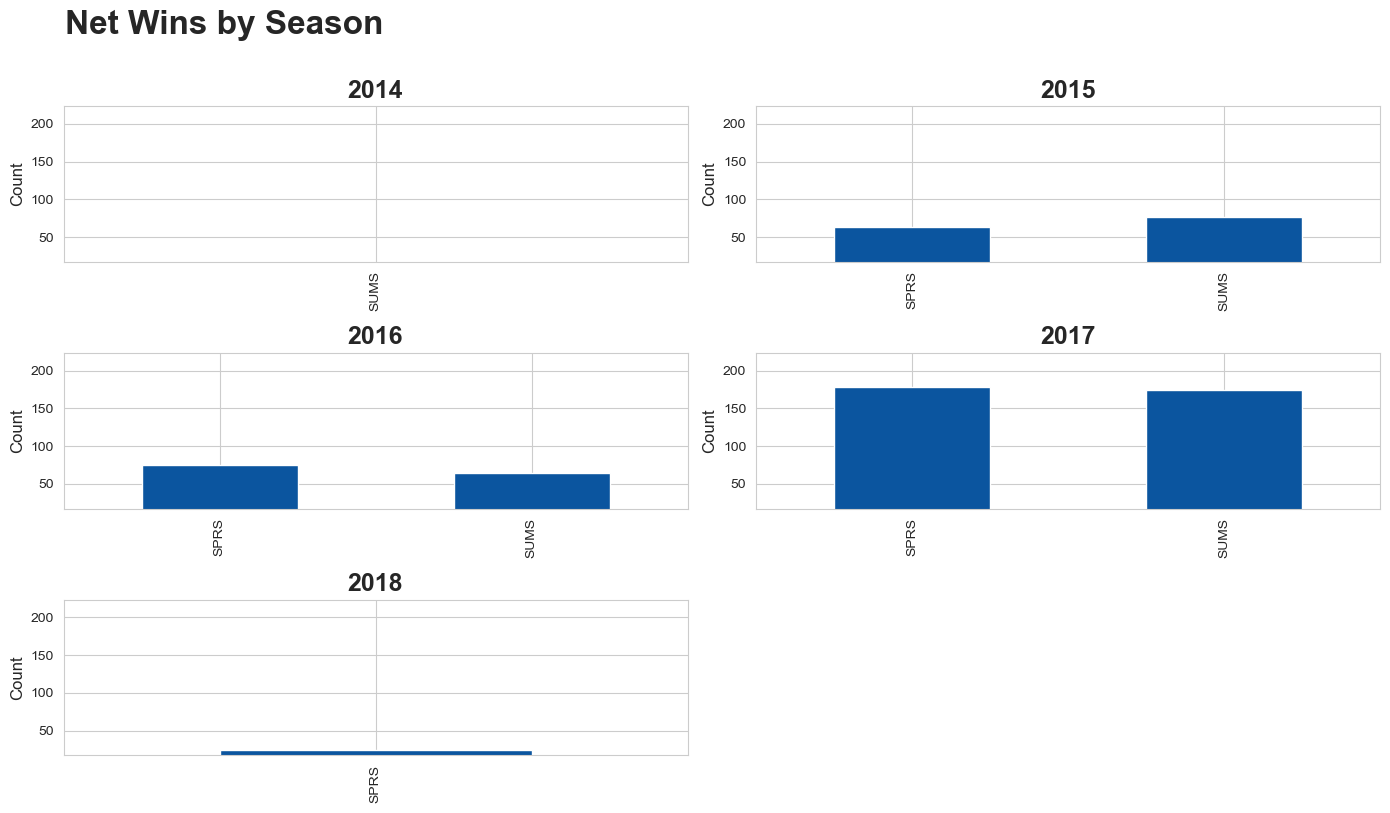

In [14]:
# Pivot by Year and Season
pvt_net_wins_ys = df.pivot_table(index = ['Year', 'SA'], values = ['bResult', 'rResult'], aggfunc=np.sum)
pvt_net_wins_ys['b_net_wins'] = pvt_net_wins_ys['bResult'] - pvt_net_wins_ys['rResult']
pvt_net_wins_ys['positive'] = pvt_net_wins_ys['b_net_wins'] > 0

# Color Formatting
blues = sns.color_palette('Blues')
reds = sns.color_palette('Reds')

lst_years = pd.unique(pvt_net_wins_yl.index.get_level_values(0))
lst_x = [1, 2, 3, 4, 5, 6, 7]

y_max = 1.25 * pvt_net_wins_ys['b_net_wins'].max()
y_min = 1.25 * pvt_net_wins_ys['b_net_wins'].min()

fig, ax = plt.subplots(2,2, figsize = (14,8))
fig.suptitle('Net Wins by Season', x=0.05, y=1.01, fontsize=24, fontweight='bold', horizontalalignment='left')

for y, x in zip(lst_years, lst_x):
    # Filter pvt for year
    pvt_net_wins_yx = pvt_net_wins_ys[np.in1d(pvt_net_wins_ys.index.get_level_values(0), y)]
    pvt_net_wins_yx = pvt_net_wins_yx.reset_index(level=0, drop=True)
    
    p = plt.subplot(3,2,x)

    # Plot across Leagues
    pvt_net_wins_yx['b_net_wins'].plot(kind='bar', 
                                       color=pvt_net_wins_yx.positive.map({True:blues[5], 
                                                                           False:reds[5]}))
    # Format each plot
    plt.title(y, fontsize= 18, fontweight='bold')
    plt.xlabel('')
    plt.ylabel('Count', fontsize=12)
    plt.ylim(y_min, y_max)
    
plt.tight_layout()
fig.subplots_adjust(top=0.89)
plt.show()  

We're seeing more or less the same when looking at it from a **Season** perspective.  

So both plots confirm the overall message communicated in the first "Wins Over Time" graph.  Blue teams win disproportionately more often than chance.

### Factorplot Tangent

Some have mentioned that using a factor plot might be more visually appealing than the above.  A few notes on this:

 - Factor plots and all the powerful visualizations that Seaborn has to offer are incredible.  But I love keeping messages as clear and simple as possible.  The concise message the above 4 plots convey allow the audience to clearly see that across time, **blue had many more wins than red**.  It's a figure that is quick and to the point.
 - Compare this to the bottom factor plot.  After a quick column addition used to create the factor plot, the output it provides consists of 32 plots consolidated in one figure.  Many of the boxes are empty, taking up unnecessary and valuable real estate, making the graph axis titles and tick marks hard to legibly fit.
  - You also have to make some judgments whether the blue or red bar is taller for certain plots, like the Spring Playoffs in 2015.  But look to 2015 SPRP and you'll quickly see that red teams edged out blue.  
  - There are certainly some benefits in being able to see all of spring playoffs in one column, but I could have put in some changes to have all 3 plots show all seasons in the same order.  
  
Keep it minimal.

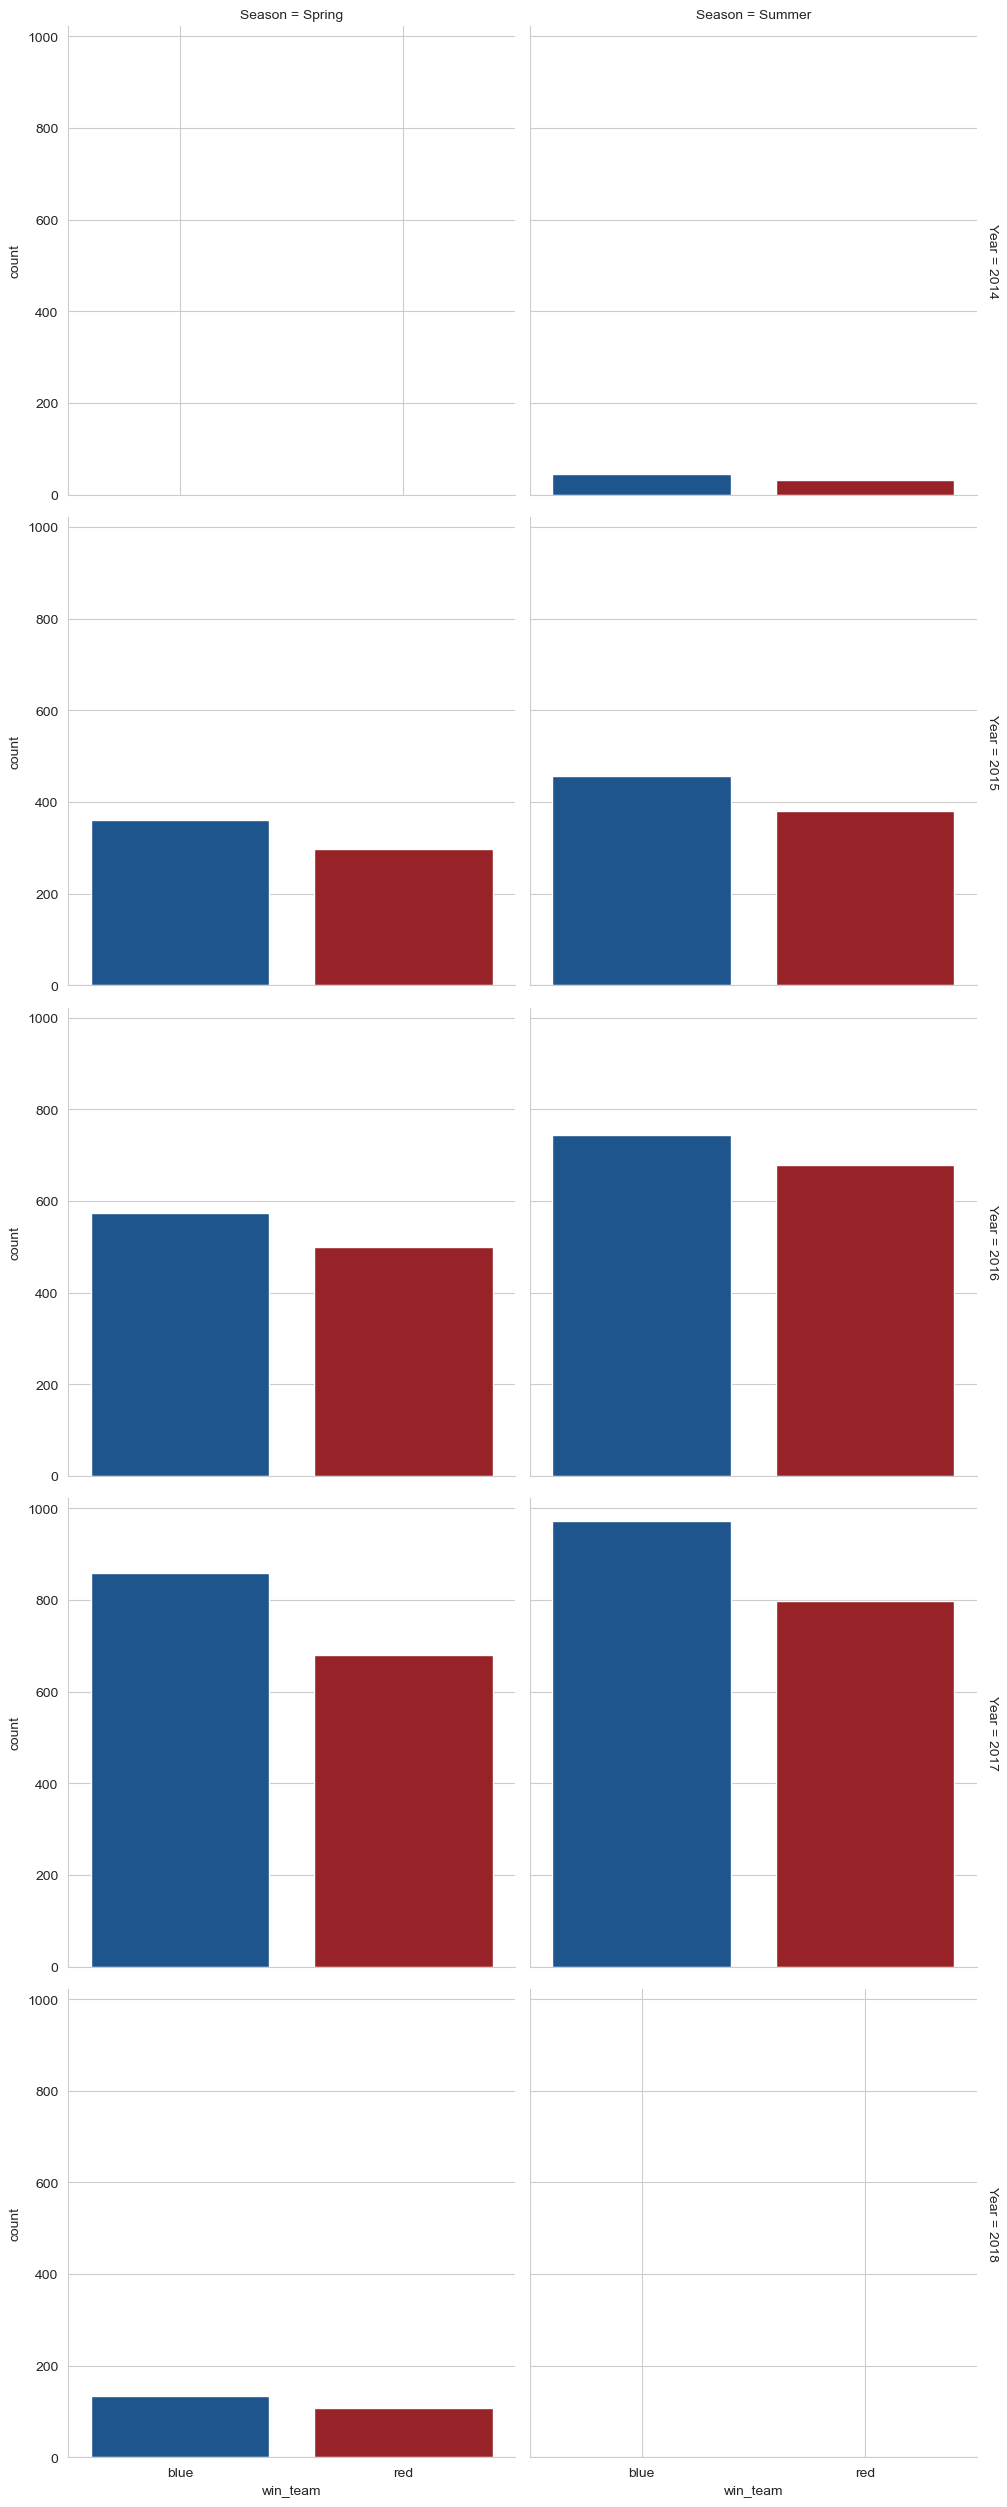

In [15]:
# Adding win team to reformat data
df['win_team'] = np.where(df['bResult']==1, 'blue', 'red')

# Creating factor plot
g = sns.factorplot(x='win_team', col='Season', row='Year', data=df, kind='count', legend_out=True, 
                  palette = {'blue':blues[5], 'red':reds[5]}, margin_titles=True)
plt.show()

Hope you agree!

## Team Attributes (Independent Variables)
Now we'll start digging into nearly every column that reveals a specific team attribute and get a feel for which are more likely to help predict wins than others.  Still cleaning, transforming, and exploring.

In [16]:
df_columns[8:16]

,ColumnName,ColumnDescription
8,redTeamTag,Red Team's Tag Name (ex. Team SoloMid is TSM) \n
9,gamelength,Game length in minutes \n
10,golddiff,Gold difference - computed Blue minus Red - b...
11,goldblue,Blue Team's total gold value by minute \n
12,bKills,"List of Blue Team's kills - [Time in minutes,..."
13,bTowers,List of minutes that Blue Team destroyed a to...
14,bInhibs,List of minutes that Blue Team destroyed an i...
15,bDragons,List of minutes that Blue Team killed a drago...


We mentioned earlier that some of these columns contain lists of values, like in row number 9 (**golddiff**) which has a **length** of list values equal to the number of minutes in the match.  So if the value in **gamelength** = 40, then there should be 40 values in the list.

I'm a bit paranoid about faulty data so let's make some high level checks to make sure this is the case.

In [17]:
# Another look
df[['gamelength', 'golddiff']].head(1)

,gamelength,golddiff
0,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,..."


In [18]:
print('gamelength value:', df['gamelength'][0])
print('golddiff list length:', len(df['golddiff'][0]))

gamelength value: 40
golddiff list length: 226


Hm, There is something wrong!!!  The **gamelength** value is 40, but the list length of **golddiff** is apparently 226.  

If we dig a bit deeper we notice that the above cell returned 226 because **golddiff** is a string data type that **looks** like a list, counting the characters within that string and not the number of values in the list.

In [19]:
print('gamelength data type:', type(df['gamelength'][0]))
print('golddiff data type:', type(df['golddiff'][0]))

gamelength data type: <class 'numpy.int64'>
golddiff data type: <class 'str'>


And unfortunately this seems to be the case throughout the columns detailing minute actions pertaining to that column.  Some even have lists within lists.

In [20]:
df[['goldblue','bKills','bTowers', 'bInhibs', 'bDragons', 'bBarons']].head()

,goldblue,bKills,bTowers,bInhibs,bDragons,bBarons
0,"[2415, 2415, 2711, 3887, 5068, 6171, 7412, 866...","[[10.82, 'C9 Hai', 'TSM Bjergsen', [], 9229, 8...","[[27.542, 'MID_LANE', 'BASE_TURRET'], [39.269,...","[[36.686, 'MID_LANE'], [29.274, 'MID_LANE']]","[[37.267, None]]",[]
1,"[2415, 2415, 2705, 4108, 5511, 6797, 7637, 895...","[[11.104, 'DIG Shiphtur', 'CST Jesiz', ['CST I...","[[23.239, 'BOT_LANE', 'OUTER_TURRET'], [33.018...",[],"[[32.545, None], [26.177, None], [19.119, None]]",[[29.255]]
2,"[2415, 2415, 2726, 3794, 4933, 6236, 8109, 965...","[[5.255, 'GV Keane', 'WFX Pobelter', ['WFX Sho...","[[15.045, 'BOT_LANE', 'OUTER_TURRET'], [39.566...","[[37.511, 'TOP_LANE'], [37.38, 'BOT_LANE'], [3...","[[24.577, None], [37.867, None], [30.87, None]...",[[35.144]]
3,"[2415, 2415, 2705, 3847, 5398, 6473, 7720, 930...","[[8.274, 'TL Quas', 'TIP Rhux', ['TIP Apollo']...","[[19.941, 'BOT_LANE', 'OUTER_TURRET'], [38.77,...",[],[],[[37.513]]
4,"[2415, 2415, 2710, 3950, 5404, 6666, 7887, 913...","[[11.438, 'T8 Dodo8', 'CLG Doublelift', ['CLG ...","[[22.594, 'MID_LANE', 'OUTER_TURRET'], [34.213...","[[34.069, 'BOT_LANE']]","[[14.589, None], [30.307, None]]",[[32.556]]


This is a ton of information and looking at even **one** list is nearly impossible to internalize. And as we saw earlier, the numbers aren't even real numbers but strings.  So a few things to do:  

 - Convert string pseudo lists to actual lists  
 - Check that the **gamelength** for a row = number of list values in gold related columns
 - Visualize a column of data


## Clean Data
Let's first convert columns populated with pseudo lists to real lists.

In [21]:
# Use literal_eval to convert golddiff to list dat atype
from ast import literal_eval
df['golddiff'] = df['golddiff'].apply(literal_eval)

# Check to make sure function works correctly
print(type(df['golddiff'][0]))
print(df['golddiff'][0])

<class 'list'>
[0, 0, -14, -65, -268, -431, -488, -789, -494, -625, -1044, -313, -760, -697, -790, -611, 240, 845, 797, 1422, 987, 169, 432, 491, 1205, 1527, 1647, 1847, 3750, 4719, 3561, 3367, 2886, 2906, 4411, 4473, 4639, 4762, 4686, 6057]


In [22]:
# Transform all other columns containing pseudo lists to real lists
df['goldblue'] = df['goldblue'].apply(literal_eval)
df['bKills'] = df['bKills'].apply(literal_eval)
df['bTowers'] = df['bTowers'].apply(literal_eval)
df['bInhibs'] = df['bInhibs'].apply(literal_eval)
df['bDragons'] = df['bDragons'].apply(literal_eval)
df['bBarons'] = df['bBarons'].apply(literal_eval)
df['bHeralds'] = df['bHeralds'].apply(literal_eval)

df['goldred'] = df['goldred'].apply(literal_eval)
df['rKills'] = df['rKills'].apply(literal_eval)
df['rTowers'] = df['rTowers'].apply(literal_eval)
df['rInhibs'] = df['rInhibs'].apply(literal_eval)
df['rDragons'] = df['rDragons'].apply(literal_eval)
df['rBarons'] = df['rBarons'].apply(literal_eval)
df['rHeralds'] = df['rHeralds'].apply(literal_eval)

df['goldblueTop'] = df['goldblueTop'].apply(literal_eval)
df['goldblueJungle'] = df['goldblueJungle'].apply(literal_eval)
df['goldblueMiddle'] = df['goldblueMiddle'].apply(literal_eval)
df['goldblueADC'] = df['goldblueADC'].apply(literal_eval)
df['goldblueSupport'] = df['goldblueSupport'].apply(literal_eval)

df['goldredTop'] = df['goldredTop'].apply(literal_eval)
df['goldredJungle'] = df['goldredJungle'].apply(literal_eval)
df['goldredMiddle'] = df['goldredMiddle'].apply(literal_eval)
df['goldredADC'] = df['goldredADC'].apply(literal_eval)
df['goldredSupport'] = df['goldredSupport'].apply(literal_eval)

Time to check that a **gamelength** value equals the **list length value** in gold related columns

In [23]:
# Checking the length of a random row in bTowers
print('golddiff:'+str(len(df['golddiff'][1234])))
print('goldblue:'+str(len(df['goldblue'][1234])))
print('goldred:'+str(len(df['goldred'][1234])))

golddiff:35
goldblue:35
goldred:35


In [24]:
df['gamelength'][1234]

35

Awesome, looks like it does.

Note that the non-gold related minute columns will **not** have list length values equal to **gamelength**.  This is because those columns (bKills, bTowers, bInhibs etc.) all list the **minute** that the team made a kill, destroyed a tower or inhibitor.  Because these events do not happen every minute, their list length will not equal **gamelength**.  We'll have to parse that data out a little differently and we'll tackle that a bit later.  Let's first see if we can draw any observations from gold related data first.

## Gold Attributes

My main goal in the sections below is to create a time series for teams that win vs those that lose.  The data frame isn't currently tailored in a way that lets us see this easily, so we'll make a few changes below.  The immediate task is to reformat the gold values by minute in the **goldblue** and **goldred** columns, identify whether that particular gold value belongs to a winning or losing team, and visualizing all of it for any quick observations.

In [25]:
# Create dictionary of games and wins 
dct_win_team = dict(zip(df.index, df['win_team']))

In [26]:
# How the df currently looks for goldblue and goldred
df[['goldblue', 'goldred']].head()

,goldblue,goldred
0,"[2415, 2415, 2711, 3887, 5068, 6171, 7412, 866...","[2415, 2415, 2725, 3952, 5336, 6602, 7900, 945..."
1,"[2415, 2415, 2705, 4108, 5511, 6797, 7637, 895...","[2415, 2415, 2731, 4126, 5364, 6560, 7789, 893..."
2,"[2415, 2415, 2726, 3794, 4933, 6236, 8109, 965...","[2415, 2415, 2716, 3854, 4899, 6199, 7520, 859..."
3,"[2415, 2415, 2705, 3847, 5398, 6473, 7720, 930...","[2415, 2415, 2720, 3822, 5170, 6479, 7963, 913..."
4,"[2415, 2415, 2710, 3950, 5404, 6666, 7887, 913...","[2375, 2375, 2666, 3986, 5291, 6508, 8008, 932..."


### Transformation 1 of 2

In [27]:
# Unstack df to dfu, reformatting data to have minutes along columns
df_gold = df[['goldblue', 'goldred']].unstack().apply(pd.Series)

# Map Level 1 to dct_win_team
df_gold['win_team'] = (df_gold.index.get_level_values(1))
df_gold['win_team'] = df_gold['win_team'].map(dct_win_team)
df_gold.head()

0       1       2       3       4       5       6       7  \
goldblue 0  2415.0  2415.0  2711.0  3887.0  5068.0  6171.0  7412.0  8661.0   
         1  2415.0  2415.0  2705.0  4108.0  5511.0  6797.0  7637.0  8953.0   
         2  2415.0  2415.0  2726.0  3794.0  4933.0  6236.0  8109.0  9656.0   
         3  2415.0  2415.0  2705.0  3847.0  5398.0  6473.0  7720.0  9308.0   
         4  2415.0  2415.0  2710.0  3950.0  5404.0  6666.0  7887.0  9131.0   

                  8        9  ...  86  87  88  89  90  91  92  93  94  \
goldblue 0  10154.0  11361.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN   
         1  10183.0  11419.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN   
         2  11073.0  12374.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN   
         3  10547.0  12033.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN   
         4  10646.0  11943.0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN   

            win_team  
goldblue 0      blue  
         1       red  
         2      blue  
         3       red  
         4      blue  

[5 rows x 96 columns]

In [28]:
# Transform "variable" index to column
df_gold = df_gold.reset_index(level=0, drop=False)
df_gold = df_gold.rename(columns={'level_0':'variable'})
df_gold.head()

,variable,0,1,2,3,4,5,6,7,8,...,86,87,88,89,90,91,92,93,94,win_team
0,goldblue,2415.0,2415.0,2711.0,3887.0,5068.0,6171.0,7412.0,8661.0,10154.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blue
1,goldblue,2415.0,2415.0,2705.0,4108.0,5511.0,6797.0,7637.0,8953.0,10183.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,red
2,goldblue,2415.0,2415.0,2726.0,3794.0,4933.0,6236.0,8109.0,9656.0,11073.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blue
3,goldblue,2415.0,2415.0,2705.0,3847.0,5398.0,6473.0,7720.0,9308.0,10547.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,red
4,goldblue,2415.0,2415.0,2710.0,3950.0,5404.0,6666.0,7887.0,9131.0,10646.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,blue


In [29]:
# Reformat dataframe to transform minute columns to a single column with the minute value within it through pd.melt
melt_gold = pd.melt(df_gold, ['variable', 'win_team'], var_name='minute')
print(melt_gold.shape)
melt_gold.head()

(1447800, 4)


,variable,win_team,minute,value
0,goldblue,blue,0,2415.0
1,goldblue,red,0,2415.0
2,goldblue,blue,0,2415.0
3,goldblue,red,0,2415.0
4,goldblue,blue,0,2415.0


Note that all columns were transformed into the minute column except those we specified in **variable** and **win_team**.

In [30]:
melt_gold['var_color'] = np.where(melt_gold['variable']=='goldblue', 'blue', 'red')
melt_gold['win'] = 'no'
melt_gold.loc[((melt_gold['var_color']=='blue') & (melt_gold['win_team']=='blue')) |
             ((melt_gold['var_color']=='red') & (melt_gold['win_team']=='red')), 
              'win'] = 'yes'
melt_gold.head()

,variable,win_team,minute,value,var_color,win
0,goldblue,blue,0,2415.0,blue,yes
1,goldblue,red,0,2415.0,blue,no
2,goldblue,blue,0,2415.0,blue,yes
3,goldblue,red,0,2415.0,blue,no
4,goldblue,blue,0,2415.0,blue,yes


In [31]:
melt_gold.shape

(1447800, 6)

In [32]:
# Check that wins for blue 
melt_gold[(melt_gold['win']=='no') & (melt_gold['win_team']=='blue')].head()

,variable,win_team,minute,value,var_color,win
7620,goldred,blue,0,2415.0,red,no
7622,goldred,blue,0,2415.0,red,no
7624,goldred,blue,0,2375.0,red,no
7626,goldred,blue,0,2415.0,red,no
7627,goldred,blue,0,2415.0,red,no


In [33]:
melt_gold[(melt_gold['win']=='no') & (melt_gold['win_team']=='red')].head()

,variable,win_team,minute,value,var_color,win
1,goldblue,red,0,2415.0,blue,no
3,goldblue,red,0,2415.0,blue,no
5,goldblue,red,0,2415.0,blue,no
8,goldblue,red,0,2415.0,blue,no
13,goldblue,red,0,2415.0,blue,no


In [34]:
melt_gold.pivot_table(index=['win_team'], values=['win'], aggfunc='count', margins=True)

,win
win_team,
blue,787740
red,660060
All,1447800


With our gold data converted to the right data type, unstacked, melted, and checked, it's finally time to visualize gold 'values' by minute for winners and losers.  It looks like 80ish minutes is the max **gamelength** so we'll split this time series up into 4 equal rows.

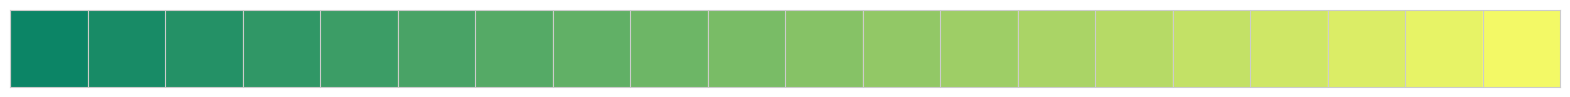

In [35]:
sns.palplot(sns.color_palette('summer', 20))
colors = sns.color_palette('summer', 20)

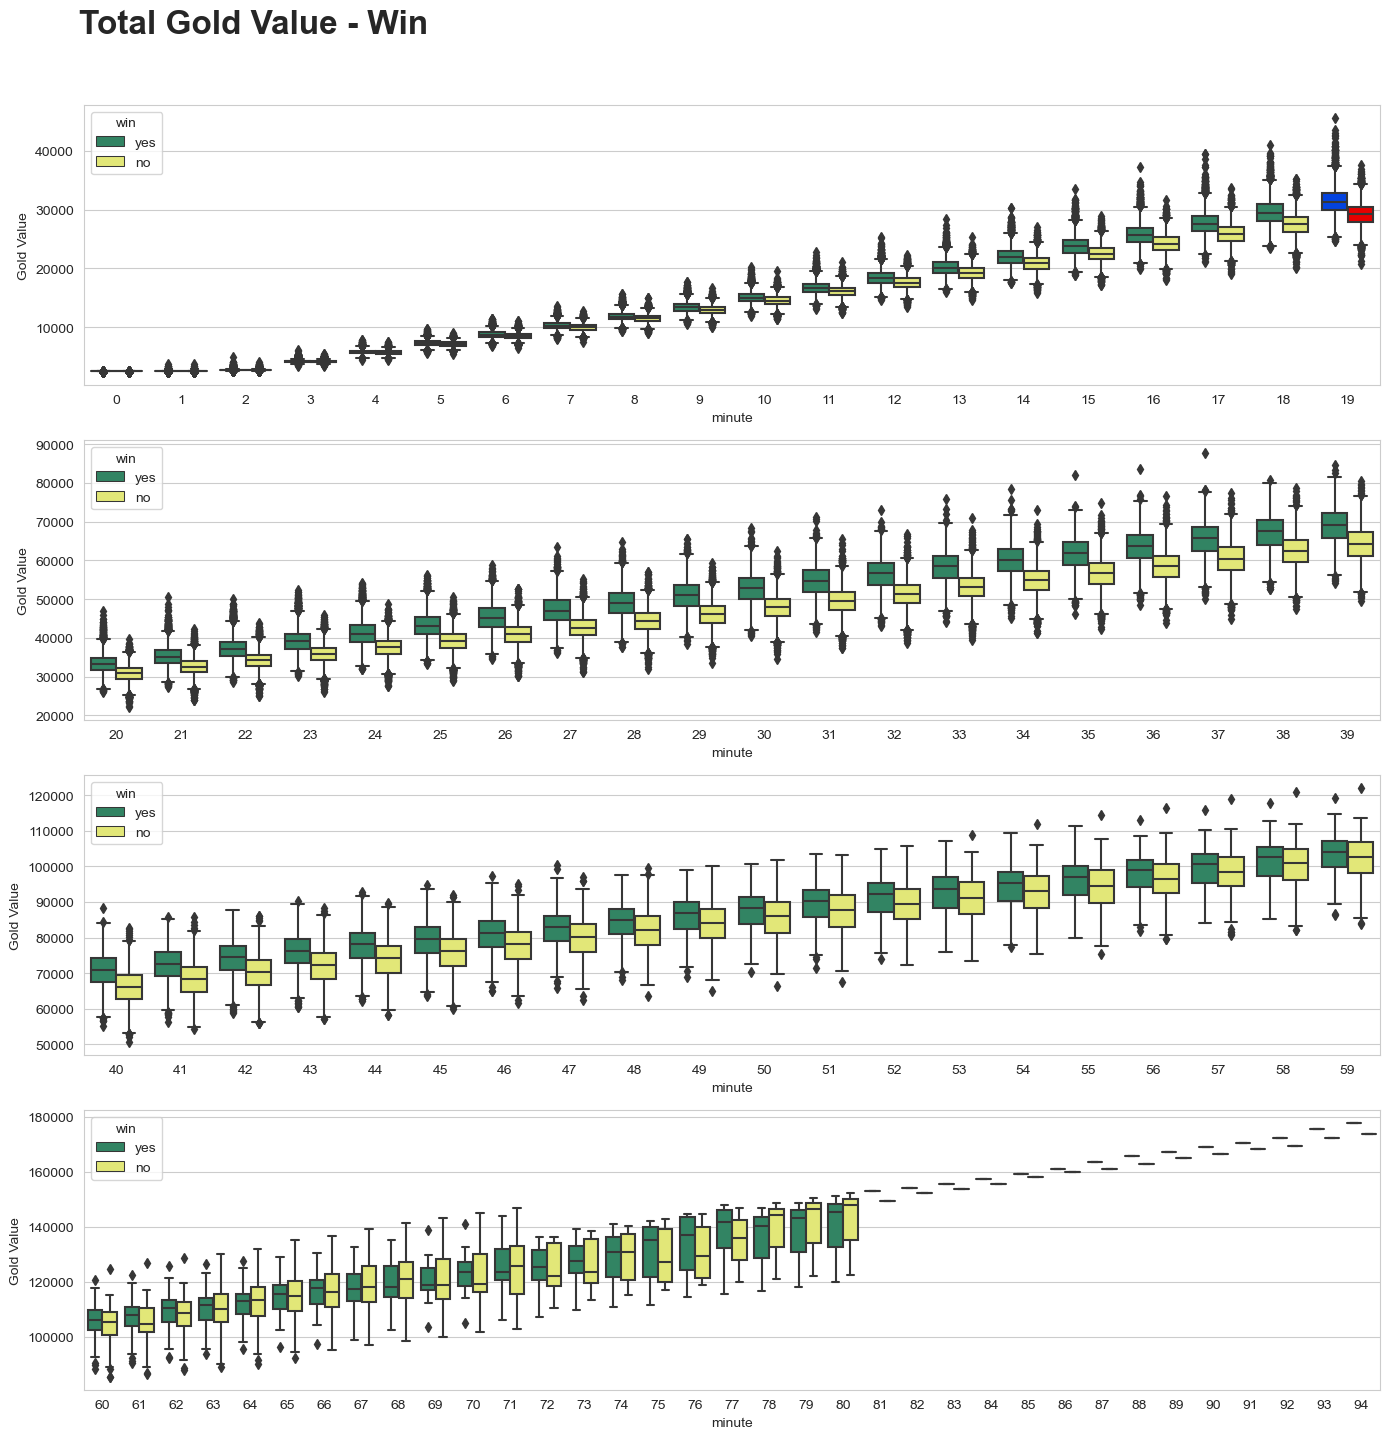

In [36]:
# Create pal dictionary using comprehension
pal = {win: colors[2] if win =='yes' else colors[19] for win in melt_gold.win.unique()}

fig, ax = plt.subplots(4,1, figsize=(14,14))
fig.suptitle('Total Gold Value - Win', fontsize=24, fontweight='bold', x=0.06, y=1.025, horizontalalignment='left')
fig.subplots_adjust(top=0.85)

plt.subplot(4,1,1)
p1 = sns.boxplot(x='minute', y='value', hue='win', data = melt_gold[melt_gold['minute']<20], 
                 palette=pal)
box = p1.artists[38] # artists allow you to access the box appearance properties of the box you want to highlight
box.set_facecolor(sns.xkcd_rgb['blue'])
box = p1.artists[39] # artists allow you to access the box appearance properties of the box you want to highlight
box.set_facecolor(sns.xkcd_rgb['red'])
plt.ylabel('Gold Value')

plt.subplot(4,1,2)
ax = sns.boxplot(x='minute', y='value', hue='win', data = melt_gold[(melt_gold['minute']>=20) & ((melt_gold['minute'] <40))],
                palette = pal)
plt.ylabel('Gold Value')

plt.subplot(4,1,3)
sns.boxplot(x='minute', y='value', hue='win', data = melt_gold[(melt_gold['minute']>=40) & ((melt_gold['minute']<60))], 
            palette=pal)
plt.ylabel('Gold Value')

plt.subplot(4,1,4)
sns.boxplot(x='minute', y='value', hue='win', data = melt_gold[(melt_gold['minute']>=60)], 
            palette=pal)
plt.ylabel('Gold Value')

plt.tight_layout()
plt.show()

### Observations
Note that the graphs below do not indicate what color team won.  These graphs only tell us how much total gold winning vs losing teams had by minute.  

**Minutes 0-19**: At the beginning of a game, the disparity in gold value is naturally pretty low.  Games are just getting started.  But as the minutes pass, it's clear that the difference in interquartile ranges (IQR = boxes, marking the 25th, 50th (median), and 75th percentiles of a distribution) for teams that win from those that lose really start to separate.  By the 19th minute (colored in blue and red), the 25th percentile (bottom of the IQR) of winning teams is nearly at the 75th percentile for losing teams.  

**Minutes 20-39**: This plot is starting to suggest that there is a cumulative advantage in taking actions to accumulate gold early.  We already spoke about how the IQRs really start to separate by the end of thee 19th minute.  Here in the second plot we see that the gold lead dramatically separates itself in minutes 20-39.  It looks like early gold value is a pretty significant factor in determining the likihood of winning at this early stage of analysis.  I'm clearly simplifying the game play a great deal here, but its hard to suggest the contrary.  We'll get a more definitive answer by the end of the notebook.

**Minutes 40-59**: Gold disparity begins to shrink.  Are winning teams during this time now more likely focused on other parts of the game?  A greater focus could be made on micromanaging units to destroy enemy structures.  We'll get some more context here when we look at these other attributes.

**Minutes 60-80**:  The IQRs here are kind of all over the place.  I somewhat disregard this data as we saw from the earlier **gamelength** plots that an insignificant minority actually reaches this period.  Only about % of games last past the 59th minute, so this entire row is more of an "eh, who really cares" subset of data. I'll leave it at that and return to this data if needed later on (although highly unlikely).

## Kill Attributes

In [37]:
df[['bKills', 'rKills']].head()

,bKills,rKills
0,"[[10.82, C9 Hai, TSM Bjergsen, [], 9229, 8469]...","[[16.529, TSM Lustboy, C9 Balls, [C9 Meteos, C..."
1,"[[11.104, DIG Shiphtur, CST Jesiz, [CST Impale...","[[12.387, CST Jesiz, DIG Gamsu, [DIG Shiphtur]..."
2,"[[5.255, GV Keane, WFX Pobelter, [WFX ShorterA...","[[8.449, WFX Altec, GV Cop, [GV BunnyFuFuu], 1..."
3,"[[8.274, TL Quas, TIP Rhux, [TIP Apollo], 3491...","[[7.768, TIP Rush, TL IWDominate, [TL Fenix], ..."
4,"[[11.438, T8 Dodo8, CLG Doublelift, [CLG Xmith...","[[11.988, CLG Doublelift, T8 Porpoise8, [T8 Sl..."


The above shows we're dealing with sublists within lists within a big giant list.  Fortunately, the 0 position of each sublist has the time the kill took place, the victim, and the killer.  The 0 position within each sublist's sublist is also a float so no string to float conversion needed here like we did with gold attributes.

In [38]:
type(df['bKills'][0][0][0])

float

On the downside, none of the lists within bKills are of equal length as we see below.

In [39]:
print(len(df['bKills'][0]))
print(len(df['bKills'][1]))
print(len(df['bKills'][2]))

16
10
22


The reason for the different lengths of lists is because there could be a wealth of **assisting** killers after.  I'm not too keen on digging into assists and feel time would be better spent focusing on the numerical data here.  I'll revisit this if our prediction model is poor.

Moving on.  Let's extract the 0 index in each sublist so that we're only looking at the time of kills within each game.

In [40]:
# Creating function to only extract  minutelist
def extract_minutes(item):
    """Extract minute list from bKills or rKills column"""
    try:
        return[item[0] for item in item]
    except:
        return[0 for item in item] # to account for empty lists

In [41]:
# Apply function to new Kills columns
df['bKills_min'] = df['bKills'].apply(extract_minutes)
df['rKills_min'] = df['rKills'].apply(extract_minutes)
df[['bKills', 'bKills_min', 'rKills', 'rKills_min']].head()

,bKills,bKills_min,rKills,rKills_min
0,"[[10.82, C9 Hai, TSM Bjergsen, [], 9229, 8469]...","[10.82, 16.286, 18.733, 18.88, 27.005, 27.029,...","[[16.529, TSM Lustboy, C9 Balls, [C9 Meteos, C...","[16.529, 16.791, 18.784, 27.073, 29.983, 30.11..."
1,"[[11.104, DIG Shiphtur, CST Jesiz, [CST Impale...","[11.104, 12.332, 12.392, 12.665, 14.837, 25.00...","[[12.387, CST Jesiz, DIG Gamsu, [DIG Shiphtur]...","[12.387, 12.689, 14.882, 25.119, 26.214, 29.35..."
2,"[[5.255, GV Keane, WFX Pobelter, [WFX ShorterA...","[5.255, 6.351, 10.628, 12.281, 12.747, 12.979,...","[[8.449, WFX Altec, GV Cop, [GV BunnyFuFuu], 1...","[8.449, 12.91, 14.23, 17.885, 19.513, 19.64, 2..."
3,"[[8.274, TL Quas, TIP Rhux, [TIP Apollo], 3491...","[8.274, 12.002, 19.12, 19.23, 19.298, 26.473, ...","[[7.768, TIP Rush, TL IWDominate, [TL Fenix], ...","[7.768, 9.681, 12.03, 13.904, 17.729, 21.026, ..."
4,"[[11.438, T8 Dodo8, CLG Doublelift, [CLG Xmith...","[11.438, 24.766, 24.844, 25.231, 25.251, 25.28...","[[11.988, CLG Doublelift, T8 Porpoise8, [T8 Sl...","[11.988, 21.451, 21.636, 24.873, 25.108, 25.21..."


In [42]:
df[['bKills', 'bKills_min', 'rKills', 'rKills_min']].shape

(7620, 4)

In [43]:
# Check to make sure function applied correctly

# First row, 3rd sublist, 0 position
print(df['bKills'][0][3][0])
# First row, 3rd value
print(df['bKills_min'][0][3])

# 125th row, 10th sublist, 0 position
print(df['bKills'][125][10][0])
# 125th row, 3rd value
print(df['bKills_min'][125][10])

18.88
18.88
29.149
29.149


Sweet.  Our extract_minutes function correctly applied to the **bKills** and **rKills** columns to create bKills_min and rKills_min.  I'm going to ultimately want plot kills on a time series basis and see their distributions by specific game, split into winners vs losers.

In [44]:
df.head()

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,redSupport,redSupportChamp,goldredSupport,redBans,Address,win_team,LA,SA,bKills_min,rKills_min
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,LemonNation,Thresh,"[515, 515, 577, 722, 911, 1042, 1194, 1370, 14...","['Tristana', 'Leblanc', 'Nidalee']",http://matchhistory.na.leagueoflegends.com/en/...,blue,NALCS,SPRS,"[10.82, 16.286, 18.733, 18.88, 27.005, 27.029,...","[16.529, 16.791, 18.784, 27.073, 29.983, 30.11..."
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",...,KiWiKiD,Annie,"[515, 515, 583, 752, 900, 1066, 1236, 1417, 15...","['RekSai', 'Janna', 'Leblanc']",http://matchhistory.na.leagueoflegends.com/en/...,red,NALCS,SPRS,"[11.104, 12.332, 12.392, 12.665, 14.837, 25.00...","[12.387, 12.689, 14.882, 25.119, 26.214, 29.35..."
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",...,BunnyFuFuu,Janna,"[515, 515, 584, 721, 858, 1002, 1168, 1303, 14...","['Leblanc', 'Zed', 'RekSai']",http://matchhistory.na.leagueoflegends.com/en/...,blue,NALCS,SPRS,"[5.255, 6.351, 10.628, 12.281, 12.747, 12.979,...","[8.449, 12.91, 14.23, 17.885, 19.513, 19.64, 2..."
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",...,Xpecial,Janna,"[515, 515, 583, 721, 870, 1059, 1205, 1342, 15...","['RekSai', 'Rumble', 'LeeSin']",http://matchhistory.na.leagueoflegends.com/en/...,red,NALCS,SPRS,"[8.274, 12.002, 19.12, 19.23, 19.298, 26.473, ...","[7.768, 9.681, 12.03, 13.904, 17.729, 21.026, ..."
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",...,Dodo8,Annie,"[475, 475, 538, 671, 817, 948, 1104, 1240, 136...","['Rumble', 'Sivir', 'Rengar']",http://matchhistory.na.leagueoflegends.com/en/...,blue,NALCS,SPRS,"[11.438, 24.766, 24.844, 25.231, 25.251, 25.28...","[11.988, 21.451, 21.636, 24.873, 25.108, 25.21..."


In [45]:
# Identify unique game ID in gameHash
print(df['Address'][1023])
print(df['Address'][1023][-16:])

http://matchhistory.na.leagueoflegends.com/en/#match-details/TRLH1/1002290126?gameHash=7090a104f0aa16f1
7090a104f0aa16f1


In [46]:
# Extract and gameID from df['MatchHistory]
gameIDs = []

for row in df['Address']:
    # Take 16 characters from end of MatchHistory and append to gameIDs
    gameIDs.append(row[-16:])

df['gameID'] = gameIDs
df['gameID'] = df['LA'] + '-' + df['gameID']

dct_index_gameID = dict(zip(df.index, df['gameID']))
dct_gameID_win = dict(zip(df['gameID'], df['win_team']))

df[['Address', 'gameID', 'win_team', 'bKills_min', 'rKills_min']].head()

,Address,gameID,win_team,bKills_min,rKills_min
0,http://matchhistory.na.leagueoflegends.com/en/...,NALCS-fbb300951ad8327c,blue,"[10.82, 16.286, 18.733, 18.88, 27.005, 27.029,...","[16.529, 16.791, 18.784, 27.073, 29.983, 30.11..."
1,http://matchhistory.na.leagueoflegends.com/en/...,NALCS-055b17da8456fdc8,red,"[11.104, 12.332, 12.392, 12.665, 14.837, 25.00...","[12.387, 12.689, 14.882, 25.119, 26.214, 29.35..."
2,http://matchhistory.na.leagueoflegends.com/en/...,NALCS-8e8a9b58df366e2d,blue,"[5.255, 6.351, 10.628, 12.281, 12.747, 12.979,...","[8.449, 12.91, 14.23, 17.885, 19.513, 19.64, 2..."
3,http://matchhistory.na.leagueoflegends.com/en/...,NALCS-0ed1cd0e0e57329c,red,"[8.274, 12.002, 19.12, 19.23, 19.298, 26.473, ...","[7.768, 9.681, 12.03, 13.904, 17.729, 21.026, ..."
4,http://matchhistory.na.leagueoflegends.com/en/...,NALCS-f932becf86175f38,blue,"[11.438, 24.766, 24.844, 25.231, 25.251, 25.28...","[11.988, 21.451, 21.636, 24.873, 25.108, 25.21..."


In [47]:
len(df)

7620

In [48]:
# Unstack df to dfu, reformatting data to have kill number along columns
df_kills = df[['bKills_min', 'rKills_min']].unstack().apply(pd.Series)
df_kills.tail()

0       1       2       3       4       5       6   \
rKills_min 7615  12.593  12.726  12.775  12.837  17.152  17.843  23.701   
           7616   3.361   8.085  11.220  11.292  13.377  20.248  20.672   
           7617   6.996   7.703  10.276  10.478  18.469  18.518  19.228   
           7618  13.399  22.150     NaN     NaN     NaN     NaN     NaN   
           7619  10.327  12.918  12.993  15.188  18.002  18.232  18.428   

                     7       8       9   ...  61  62  63  64  65  66  67  68  \
rKills_min 7615  23.745  23.960  29.538  ... NaN NaN NaN NaN NaN NaN NaN NaN   
           7616  20.684  20.885  23.833  ... NaN NaN NaN NaN NaN NaN NaN NaN   
           7617  19.289  22.536  22.628  ... NaN NaN NaN NaN NaN NaN NaN NaN   
           7618     NaN     NaN     NaN  ... NaN NaN NaN NaN NaN NaN NaN NaN   
           7619  18.508  25.515  25.707  ... NaN NaN NaN NaN NaN NaN NaN NaN   

                 69  70  
rKills_min 7615 NaN NaN  
           7616 NaN NaN  
           7617 NaN NaN  
           7618 NaN NaN  
           7619 NaN NaN  

[5 rows x 71 columns]

In [49]:
# Map Level 1 index to dct_index_gameID and dct_win_team
df_kills['gameID'] = (df_kills.index.get_level_values(1))
df_kills['gameID'] = df_kills['gameID'].map(dct_index_gameID)

df_kills['win_team'] = (df_kills.index.get_level_values(1))
df_kills['win_team'] = df_kills['gameID'].map(dct_gameID_win)

# Transform "variable" index to column
df_kills = df_kills.reset_index(level=0, drop=False)
df_kills = df_kills.rename(columns={'level_0':'variable'})
df_kills.head()

,variable,0,1,2,3,4,5,6,7,8,...,63,64,65,66,67,68,69,70,gameID,win_team
0,bKills_min,10.820,16.286,18.733,18.880,27.005,27.029,27.109,28.989,29.073,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NALCS-fbb300951ad8327c,blue
1,bKills_min,11.104,12.332,12.392,12.665,14.837,25.008,25.134,28.412,30.128,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NALCS-055b17da8456fdc8,red
2,bKills_min,5.255,6.351,10.628,12.281,12.747,12.979,12.992,14.247,17.777,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NALCS-8e8a9b58df366e2d,blue
3,bKills_min,8.274,12.002,19.120,19.230,19.298,26.473,29.102,36.557,37.052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NALCS-0ed1cd0e0e57329c,red
4,bKills_min,11.438,24.766,24.844,25.231,25.251,25.289,26.685,26.719,28.002,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NALCS-f932becf86175f38,blue


In [50]:
df_kills.shape

(15240, 74)

In [51]:
# Reformat dataframe to transform columns (kill number) to a single column with the minute value within it through pd.melt
melt_kills = pd.melt(df_kills, ['gameID', 'variable', 'win_team'], var_name='action_count').fillna(0)
melt_kills.head()

,gameID,variable,win_team,action_count,value
0,NALCS-fbb300951ad8327c,bKills_min,blue,0,10.820
1,NALCS-055b17da8456fdc8,bKills_min,red,0,11.104
2,NALCS-8e8a9b58df366e2d,bKills_min,blue,0,5.255
3,NALCS-0ed1cd0e0e57329c,bKills_min,red,0,8.274
4,NALCS-f932becf86175f38,bKills_min,blue,0,11.438


In [52]:
# Additional melt_kills columns
melt_kills['var_color'] = np.where(melt_kills['variable']=='bKills_min', 'blue', 'red')

melt_kills['win'] = False
melt_kills.loc[((melt_kills['var_color']=='blue') & (melt_kills['win_team']=='blue')) | 
               ((melt_kills['var_color']=='red') & (melt_kills['win_team']=='red')), 'win'] = True

melt_kills['action_count'] = melt_kills['action_count'] + 1
melt_kills['minute_bin'] = pd.cut(melt_kills['value'], bins=np.arange(0,82,5))
melt_kills.head()

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
0,NALCS-fbb300951ad8327c,bKills_min,blue,1,10.820,blue,True,"(10, 15]"
1,NALCS-055b17da8456fdc8,bKills_min,red,1,11.104,blue,False,"(10, 15]"
2,NALCS-8e8a9b58df366e2d,bKills_min,blue,1,5.255,blue,True,"(5, 10]"
3,NALCS-0ed1cd0e0e57329c,bKills_min,red,1,8.274,blue,False,"(5, 10]"
4,NALCS-f932becf86175f38,bKills_min,blue,1,11.438,blue,True,"(10, 15]"


In [53]:
melt_kills[melt_kills['gameID']=='NALCS-fbb300951ad8327c'][:35]

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
0,NALCS-fbb300951ad8327c,bKills_min,blue,1,10.820,blue,True,"(10.0, 15.0]"
7620,NALCS-fbb300951ad8327c,rKills_min,blue,1,16.529,red,False,"(15.0, 20.0]"
15240,NALCS-fbb300951ad8327c,bKills_min,blue,2,16.286,blue,True,"(15.0, 20.0]"
22860,NALCS-fbb300951ad8327c,rKills_min,blue,2,16.791,red,False,"(15.0, 20.0]"
30480,NALCS-fbb300951ad8327c,bKills_min,blue,3,18.733,blue,True,"(15.0, 20.0]"
38100,NALCS-fbb300951ad8327c,rKills_min,blue,3,18.784,red,False,"(15.0, 20.0]"
45720,NALCS-fbb300951ad8327c,bKills_min,blue,4,18.880,blue,True,"(15.0, 20.0]"
53340,NALCS-fbb300951ad8327c,rKills_min,blue,4,27.073,red,False,"(25.0, 30.0]"
60960,NALCS-fbb300951ad8327c,bKills_min,blue,5,27.005,blue,True,"(25.0, 30.0]"
68580,NALCS-fbb300951ad8327c,rKills_min,blue,5,29.983,red,False,"(25.0, 30.0]"


### Kill Data Recap
That was a lot of code without a lot of explanation that a lot of you may have skipped.  In short, we've reformatted the kill metrics to make it easily plottable.  First a look at Kill distributions.

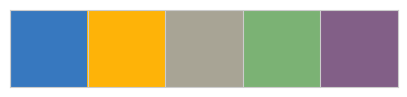

In [54]:
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
sns.palplot(sns.xkcd_palette(colors))

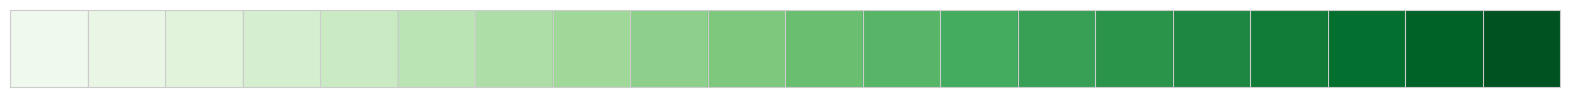

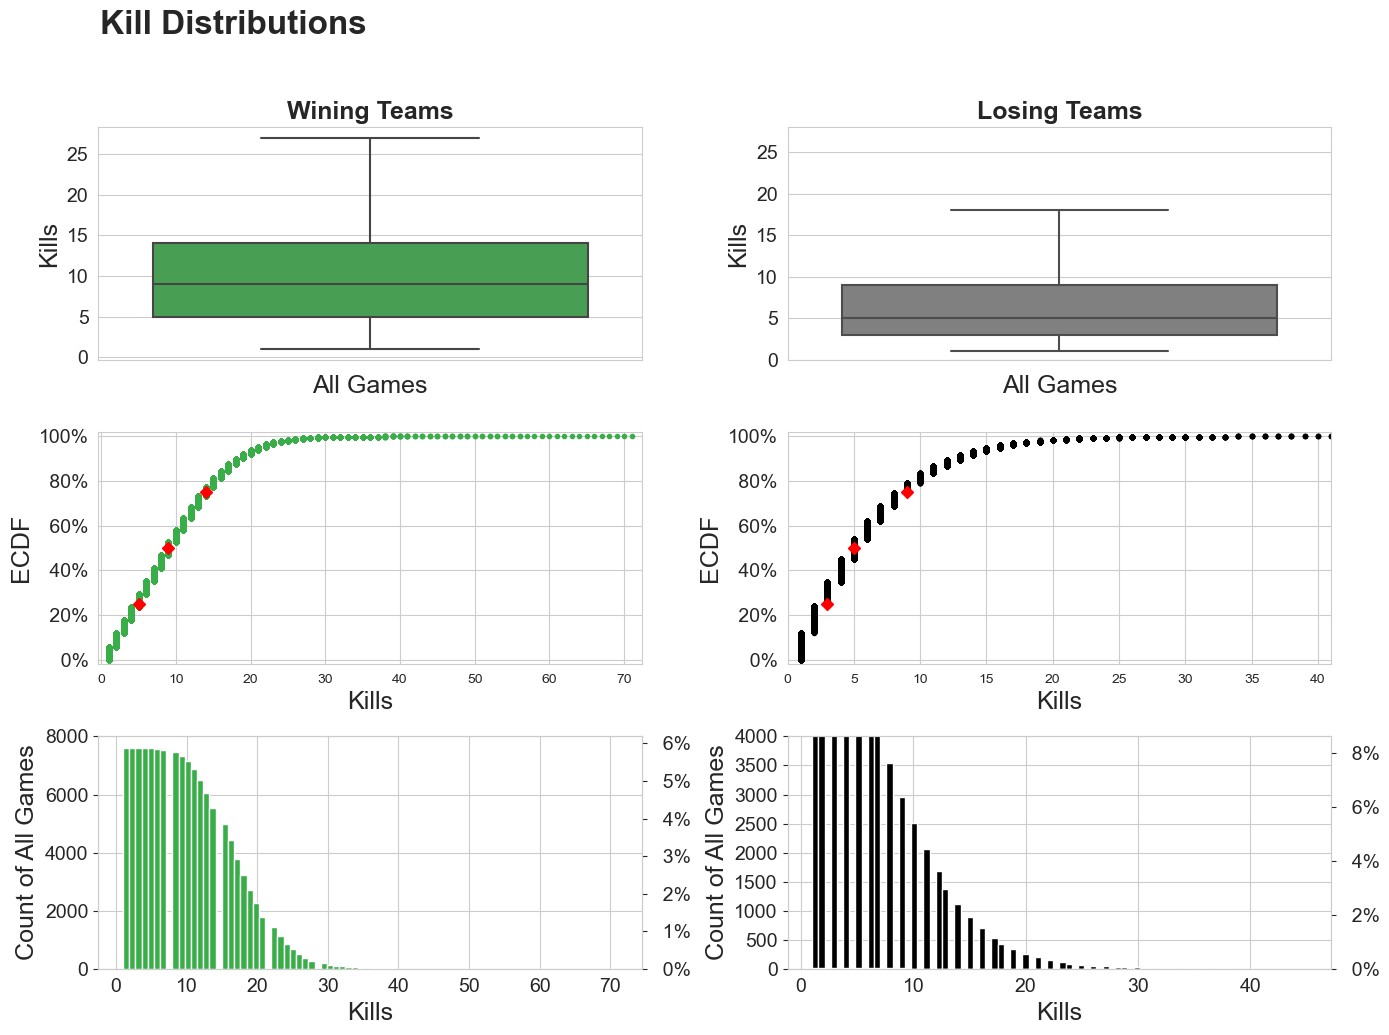

In [55]:
df_kills = melt_kills[melt_kills['minute_bin'].notnull()]
df_kills_win = df_kills[df_kills['win']==True]
df_kills_lose = df_kills[df_kills['win']==False]

# Setstyle options
sns.set_style('whitegrid')
sns.palplot(sns.color_palette('Greens', 20))
color_win = sns.xkcd_rgb['medium green']
color_lose = 'black'

# Create Figure
fig, ax = plt.subplots(3,2, figsize=(14,10))
fig.suptitle('Kill Distributions', x=0.075, y=1.03, fontsize=24, fontweight='bold', 
             horizontalalignment='left')
fig.subplots_adjust(top=0.9)

percentiles = np.array([25, 50, 75])

# Create Subplots

# ------------------------------------- WIN -------------------------------------

# 1 Box and Whisker
p1 = plt.subplot2grid((3,2), (0,0), colspan=1)
sns.boxplot(y=df_kills_win['action_count'], color=color_win, showfliers=False)
plt.title('Wining Teams', fontsize=18, fontweight='bold')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('All Games', fontsize=18)
plt.ylabel('Kills', fontsize = 18)

# 2 ECDF Plot
p2 = plt.subplot2grid((3,2), (1,0), colspan=1)
x = np.sort(df_kills_win['action_count'])
y = np.arange(1, len(x) + 1) / len(x)
ptiles_gl_win = np.percentile(df_kills_win['action_count'], percentiles)
plt.plot(x,y, marker='.', linestyle='none', color=color_win)
plt.plot(ptiles_gl_win, percentiles/100, marker='D', color='red', linestyle='none')

# 2 ECDF Formatting (a lot)
yvals = p2.get_yticks()
p2.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])
plt.yticks(fontsize=14)
plt.xlabel('Kills', fontsize=18)
plt.ylabel('ECDF', fontsize=18)
plt.margins(0.02)

# 3 Histogram Count
p3 = plt.subplot2grid((3,2), (2,0), colspan=1)
plt.hist(x='action_count', bins=80, data=df_kills_win, color=color_win)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Kills', fontsize = 18)
plt.ylabel('Count of All Games', fontsize=18)

# 3 Histogram Percentage - Second Y Axis for Percent (To DO - align Y2 ytick values to Y1 ytick lines)
weights = np.ones_like(df_kills_win['action_count']) / len(df_kills_win['action_count'])
p3 = plt.twinx()
plt.hist(x='action_count', bins=80, weights= weights, data=df_kills_win, color=color_win)
yvals = p3.get_yticks()
p3.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
p3.grid(b=False)


# ------------------------------------- LOSE -------------------------------------

# 4 Box and Whisker
p4 = plt.subplot2grid((3,2), (0,1), colspan=1)
sns.boxplot(y=df_kills_lose['action_count'], color='grey', showfliers=False)
plt.title('Losing Teams', fontsize=18, fontweight = 'bold')
plt.ylim(0,28)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('All Games', fontsize=18)
plt.ylabel('Kills', fontsize = 18)

# 5 ECDF Plot
p5 = plt.subplot2grid((3,2), (1,1), colspan=1)
ptiles_gl_lose = np.percentile(df_kills_lose['action_count'], percentiles)
x = np.sort(df_kills_lose['action_count'])
y = np.arange(1, len(x) + 1) / len(x)
plt.plot(x,y, marker='.', linestyle='none', color=color_lose)
plt.plot(ptiles_gl_lose, percentiles/100, marker='D', color='red', linestyle='none')

# 5 ECDF Formatting (a lot)
yvals = p5.get_yticks()
p5.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])

plt.yticks(fontsize=14)
plt.xlim(0, 41)
plt.xlabel('Kills', fontsize=18)
plt.ylabel('ECDF', fontsize=18)
plt.margins(0.02)

# 6 Histogram Count
p6 = plt.subplot2grid((3,2), (2,1), colspan=1)
plt.hist(x='action_count', bins=80, data=df_kills_lose, color='black')
plt.ylim(0,4000)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel('Kills', fontsize = 18)
plt.ylabel('Count of All Games', fontsize=18)

# 6 Histogram Percentage - Second Y Axis for Percent (To DO - align Y2 ytick values to Y1 ytick lines)
weights = np.ones_like(df_kills_lose['action_count']) / len(df_kills_lose['action_count'])
p6 = plt.twinx()
plt.hist(x='action_count', bins=80, weights= weights, data=df_kills_lose, color=color_lose)
yvals = p6.get_yticks()
p6.set_yticklabels(['{:3.0f}%'.format(y*100) for y in yvals])
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.ylim(0,43)
p6.grid(b=False)

# Show everything
plt.tight_layout()
plt.show()

### Kill distributions

We can also now say that for every specific game we know whether a kill belonged to the winning or losing team of that game and what minute in the game the kill happened.  The below illustrates this for us across 4 games.

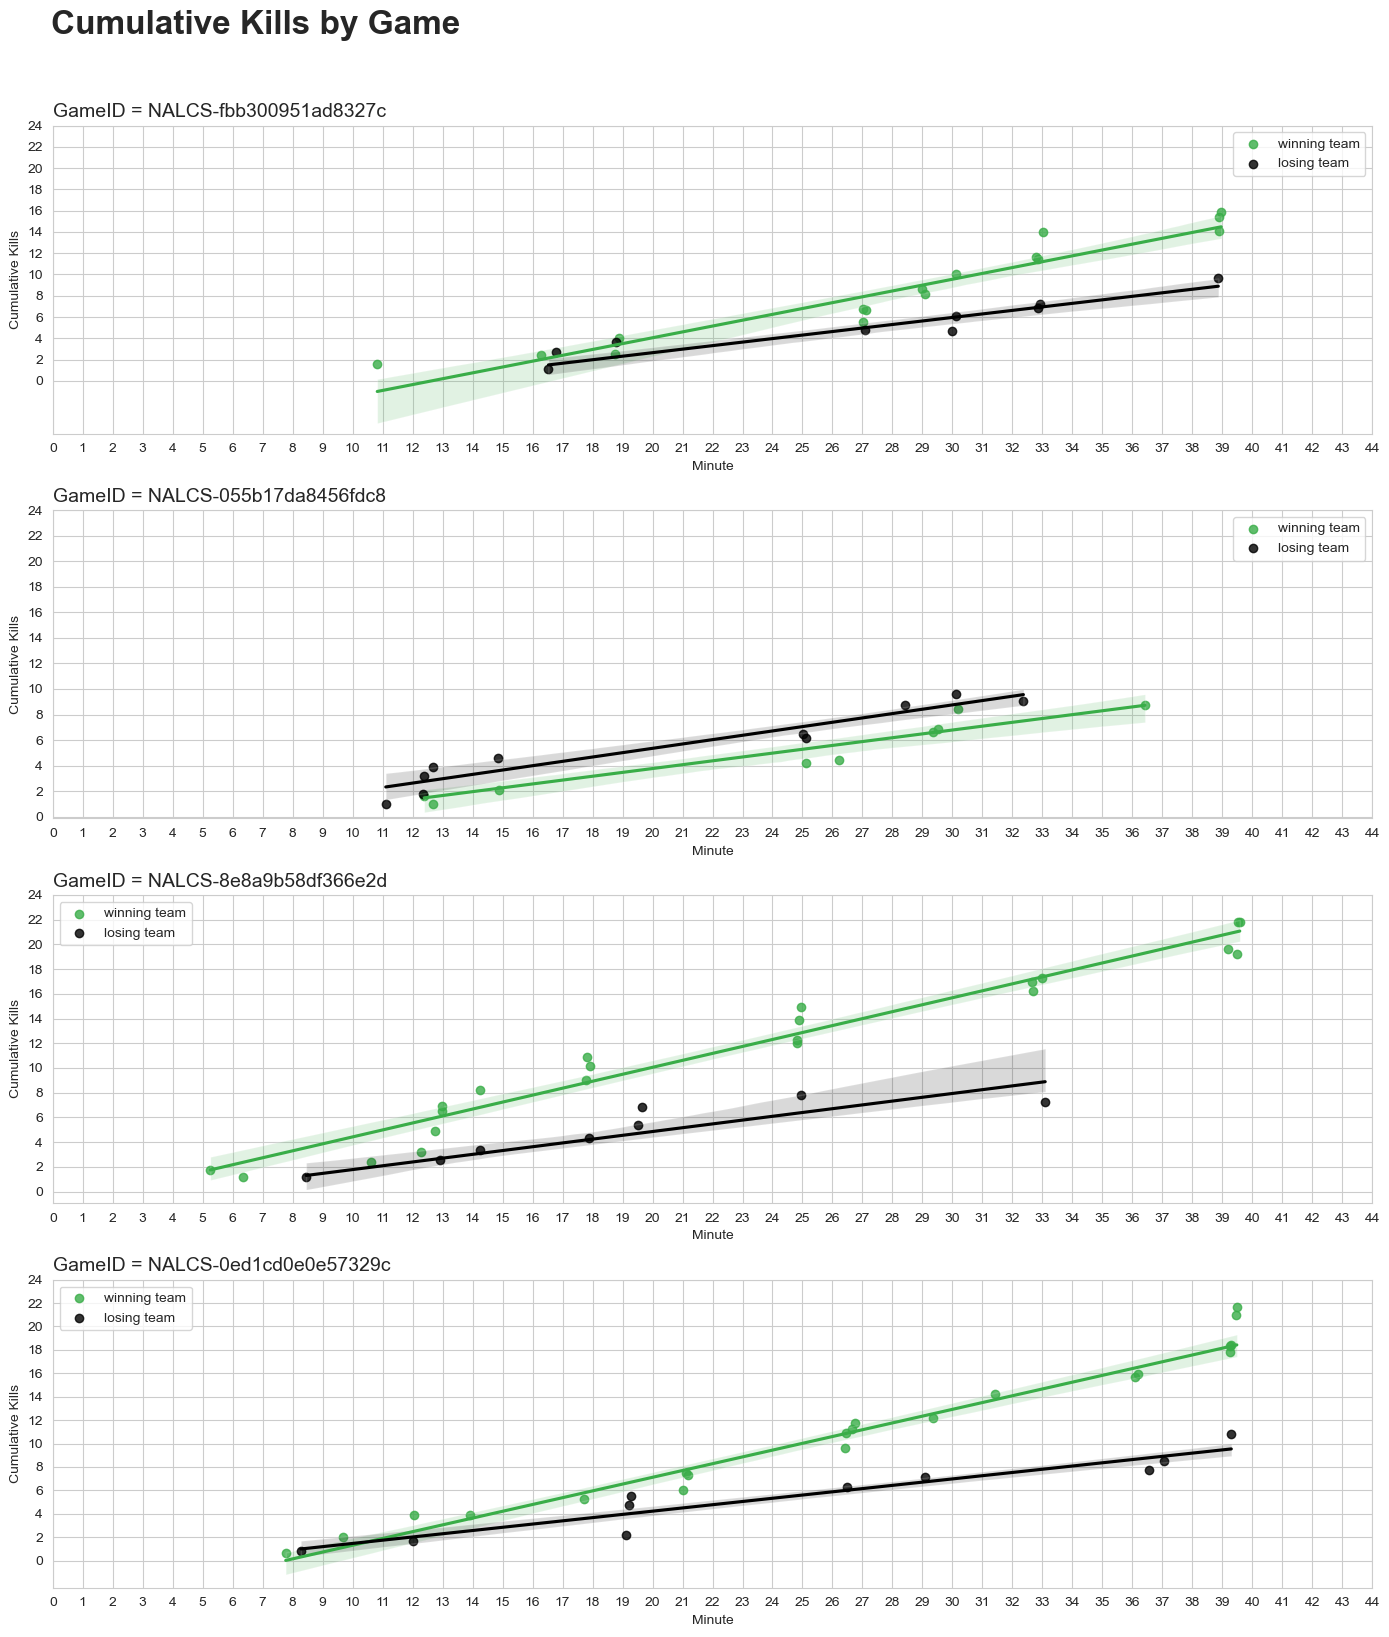

In [56]:
lst_gameID = pd.unique(df['gameID'])
games = 4
lst_games = list(np.arange(0,games,1))

fig, ax = plt.subplots(figsize=(14,16))
fig.suptitle('Cumulative Kills by Game', fontsize= 24, fontweight='bold', x=0.04, y=1.02, horizontalalignment='left')
fig.subplots_adjust(top=0.85)

for g, c in zip(lst_gameID, lst_games):
    gameID = lst_gameID[c]
    
    ax = plt.subplot(games,1,c+1)

    df_kills = melt_kills[(melt_kills['gameID']==gameID) & melt_kills['minute_bin'].notnull()]

    plt.title('GameID = ' + gameID, fontsize= 14, loc='left')
    sns.regplot(x="value", y="action_count", y_jitter=True, data=df_kills[df_kills['win']==True], color=color_win, 
                label='winning team')
    sns.regplot(x="value", y="action_count", y_jitter=True, data=df_kills[df_kills['win']==False], color=color_lose, 
                label='losing team')
    plt.yticks(np.arange(0, 25, 2))
    plt.xticks(np.arange(0, 45, 1))
    plt.ylabel('Cumulative Kills')
    plt.xlabel('Minute')

    ax.legend(loc='best')

plt.tight_layout()
plt.show()

### Kill Notes
The above takes a look at the first 4 games and the kill cadence by minute.  We can see that the trendline slopes of the winning teams (green) are mainly steeper than and above those on the losing teams (black).  It makes sense that a greater number of kills than your opponent and before your opponent translates to wins makes sense.  We see that this is the case in 3 out of the 4 games we picked.  Time to compress all games in a plot to **confirm** this.

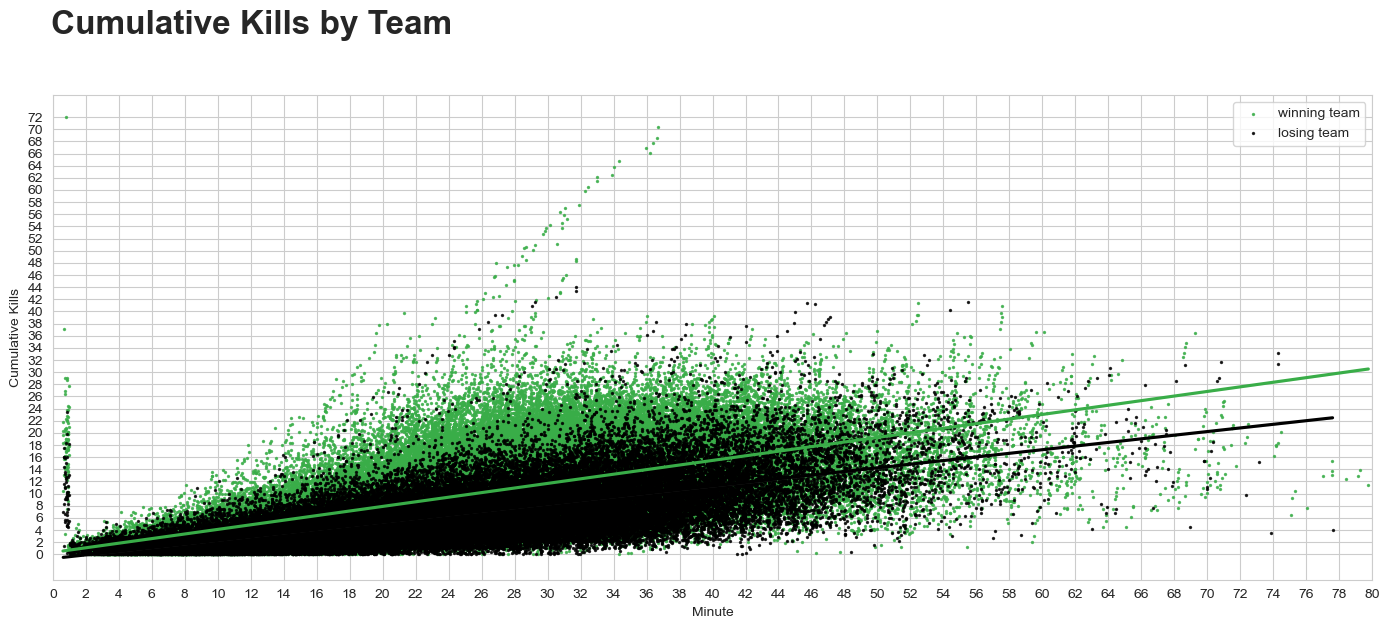

In [57]:
df_kills = melt_kills[melt_kills['minute_bin'].notnull()]

fig, ax = plt.subplots(figsize=(14,6))
fig.suptitle('Cumulative Kills by Team', fontsize= 24, fontweight='bold', x=0.04, y=1.04, horizontalalignment='left')
# fig.subplots_adjust(top=0.85)

ax = plt.subplot(111)

sns.regplot(x="value", y="action_count", y_jitter=True, data=df_kills[df_kills['win']==True], color=color_win, 
            label='winning team', scatter_kws={'s':2})
sns.regplot(x="value", y="action_count", y_jitter=True, data=df_kills[df_kills['win']==False], color=color_lose, 
            label='losing team', scatter_kws={'s':2})
plt.yticks(np.arange(0, max(df_kills['action_count'])+2, 2))
plt.xticks(np.arange(0, max(df_kills['value'])+2, 2))
plt.ylabel('Cumulative Kills')
plt.xlabel('Minute')

ax.legend(loc='best')

plt.tight_layout()
plt.show()

**Confirmed.**  But I think what's much more interesting is the likelihood of winning based on the number of kills a team gets at a certain point in the game.  Specifically, if the a team gets 2 kills within the 5 minutes, what is the likelihood of the blue team winning?  Is there really a cumulative advantage in getting kills early?  Let's use logistic regression to see win probabilities for teams according to the number of kills made on a minute by minute basis.

In [58]:
df_test = df_kills[df_kills['value']<1]
print('Rows:', len(df_test))
print('Unique Games:',len(pd.unique(df_test['gameID'])))
df_test.head()

Rows: 140
Unique Games: 127


,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
2255,LCK-e946010e7b705015,bKills_min,blue,1,0.914,blue,True,"(0, 5]"
2266,LCK-eaa1584a379e179c,bKills_min,blue,1,0.925,blue,True,"(0, 5]"
2303,LCK-c627f4419d5687ef,bKills_min,blue,1,0.907,blue,True,"(0, 5]"
2423,LCK-3d1d826f1ee4f8e6,bKills_min,red,1,0.940,blue,False,"(0, 5]"
9742,LCK-6931ee04aa3956c5,rKills_min,blue,1,0.845,red,False,"(0, 5]"


### Observations
Allegedly there were 58 games were at least one kill was made in the first minute.  What makes this data suspicious to me is the action count you see above.  Take any of the first 5 rows and you'll see the data suggests that 5 kills were made within the first minute.  While that seems impossible, a quick youtube find shows that indeed, a team had 6 kills in the first minute.  But 
I dug a little deeper into the first game and found the below.

In [59]:
df_kills[df_kills['gameID']=='LCK-e946010e7b705015']

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
2255,LCK-e946010e7b705015,bKills_min,blue,1,0.914,blue,True,"(0, 5]"
9875,LCK-e946010e7b705015,rKills_min,blue,1,3.490,red,False,"(0, 5]"
17495,LCK-e946010e7b705015,bKills_min,blue,2,3.858,blue,True,"(0, 5]"
25115,LCK-e946010e7b705015,rKills_min,blue,2,3.796,red,False,"(0, 5]"
32735,LCK-e946010e7b705015,bKills_min,blue,3,3.937,blue,True,"(0, 5]"
40355,LCK-e946010e7b705015,rKills_min,blue,3,21.448,red,False,"(20, 25]"
47975,LCK-e946010e7b705015,bKills_min,blue,4,7.319,blue,True,"(5, 10]"
55595,LCK-e946010e7b705015,rKills_min,blue,4,32.530,red,False,"(30, 35]"
63215,LCK-e946010e7b705015,bKills_min,blue,5,9.395,blue,True,"(5, 10]"
70835,LCK-e946010e7b705015,rKills_min,blue,5,34.469,red,False,"(30, 35]"


Looks like the above game had 5 kills within the 1 minute mark here.  You can also see the data is a bit out order.  Very fishy that the alleged 5th kill  (action_count) for red happened at the 0.933 minute mark.  Why is this not the first action count?  Let's check back to df and see if we misaligned the data somehow.

In [60]:
df[['gameID', 'rKills', 'rKills_min']][df['gameID']=='LCK-e946010e7b705015']

,gameID,rKills,rKills_min
2255,LCK-e946010e7b705015,"[[3.49, NJE Duke, SSG Eve, [SSG CuVee, SSG Fur...","[3.49, 3.796, 21.448, 32.53, 34.469, 34.516]"


In [61]:
df['rKills'][889]

[[11.89, 'FLY Hai', 'IMT Pobelter', ['IMT Xmithie'], 5614, 7408],
 [15.144,
  'FLY WildTurtle',
  'IMT Olleh',
  ['IMT Flame', 'IMT Cody Sun'],
  12675,
  1616],
 [15.379, 'FLY Balls', 'IMT Pobelter', ['IMT Xmithie'], 3219, 13258],
 [19.288, 'FLY Balls', 'IMT Flame', ['IMT Pobelter'], 8992, 1099],
 [19.456, 'FLY WildTurtle', 'IMT Cody Sun', [], 2864, 11812],
 [22.028,
  'FLY Hai',
  'IMT Xmithie',
  ['IMT Flame', 'IMT Pobelter', 'IMT Olleh'],
  9373,
  8753],
 [27.105,
  'FLY Hai',
  'IMT Cody Sun',
  ['IMT Xmithie', 'IMT Pobelter', 'IMT Olleh'],
  11128,
  12313],
 [30.07,
  'FLY Balls',
  'IMT Cody Sun',
  ['IMT Flame', 'IMT Pobelter', 'IMT Olleh'],
  10469,
  13938]]

### Verdict
It looks like our data reformat efforts worked perfectly fine.  But this "TooEarly" Victim and "TooEarly" Killer is really weird at 0.933.  A dive into the number of instances where "TooEarly" is both the Victim and Killer totals to 67 times.  It's exactly the number of instances where kills were found in < 1 minute (df_test above).  It's also intersting that red doesn't have any more kills after this "TooEarly" kill.  Same applies for other games as well as shown below.  Too much of this seems fishy to me and I'm perfectly comfortable removing these 67 points from the dataset.

In [62]:
df_kills[df_kills['gameID']=='LCK-198df12c6b9433a9']

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
2802,LCK-198df12c6b9433a9,bKills_min,blue,1,2.479,blue,True,"(0, 5]"
10422,LCK-198df12c6b9433a9,rKills_min,blue,1,12.998,red,False,"(10, 15]"
18042,LCK-198df12c6b9433a9,bKills_min,blue,2,10.830,blue,True,"(10, 15]"
25662,LCK-198df12c6b9433a9,rKills_min,blue,2,14.188,red,False,"(10, 15]"
33282,LCK-198df12c6b9433a9,bKills_min,blue,3,10.833,blue,True,"(10, 15]"
40902,LCK-198df12c6b9433a9,rKills_min,blue,3,14.372,red,False,"(10, 15]"
48522,LCK-198df12c6b9433a9,bKills_min,blue,4,11.379,blue,True,"(10, 15]"
56142,LCK-198df12c6b9433a9,rKills_min,blue,4,14.465,red,False,"(10, 15]"
63762,LCK-198df12c6b9433a9,bKills_min,blue,5,13.706,blue,True,"(10, 15]"
71382,LCK-198df12c6b9433a9,rKills_min,blue,5,0.900,red,False,"(0, 5]"


In [63]:
# Remove kills less than 1 minute.
print('Rows pre 1 minute exlusion:',len(df_kills))
df_kills = df_kills[df_kills['value']>=1]
print('Rows post 1 minute exlusion:',len(df_kills))

Rows pre 1 minute exlusion: 190951
Rows post 1 minute exlusion: 190811


In [64]:
df_kills_min_x = df_kills.copy(deep=True)
df_kills_min_x = df_kills_min_x[(df_kills_min_x['value']<=2)]
print(pd.unique(df_kills_min_x['action_count']))
print(len(pd.unique(df_kills_min_x['gameID'])))

[1 2 3 4 5]
226


So there were 117 games where at least 1 kill was made within the first 2 minutes and at least 1 game where 5 kills happened within the first 2 minutes.  Possible, but I do want to see how the latter game was laid out.  

In [65]:
df_kills_min_x[df_kills_min_x['action_count']>2]

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
32904,LCK-a4f63fc013228353,bKills_min,blue,3,1.614,blue,True,"(0, 5]"
36875,WC-763613ed628ef784,bKills_min,blue,3,1.334,blue,True,"(0, 5]"
38646,NALCS-4a4c51497cd20b05,rKills_min,blue,3,1.551,red,False,"(0, 5]"
42728,TCL-ec69ef0aaf48c3ff,rKills_min,red,3,1.807,red,True,"(0, 5]"
52115,WC-763613ed628ef784,bKills_min,blue,4,1.403,blue,True,"(0, 5]"
67355,WC-763613ed628ef784,bKills_min,blue,5,1.521,blue,True,"(0, 5]"


In [66]:
df_kills_min_x[df_kills_min_x['gameID']=='SWC-763613ed628ef784']

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin


Nothing fishy here.  Let's check the NA game with 3 kills within the first 2 minutes and be done with these sense checks.

In [67]:
df_kills_min_x[df_kills_min_x['gameID']=='LCK-a4f63fc013228353']

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
2424,LCK-a4f63fc013228353,bKills_min,blue,1,1.333,blue,True,"(0, 5]"
17664,LCK-a4f63fc013228353,bKills_min,blue,2,1.394,blue,True,"(0, 5]"
32904,LCK-a4f63fc013228353,bKills_min,blue,3,1.614,blue,True,"(0, 5]"


Looks fine.  Time to apply some logistic regression.  The dependent variable (what we're trying to predict for) will be "win" and the independent variable will be "action_count."

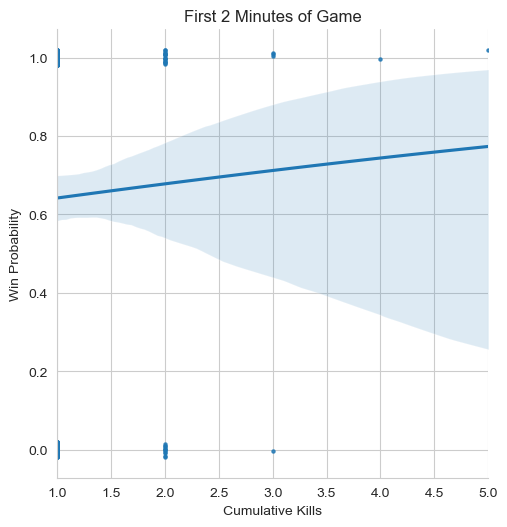

In [68]:
sns.lmplot(x='action_count', y='win', data=df_kills_min_x, 
           y_jitter=.02, logistic=True, scatter_kws={'s':5})
plt.title('First 2 Minutes of Game')
plt.ylabel('Win Probability')
plt.xlabel('Cumulative Kills')
plt.show()

### Observation - Kills Within 2 Minutes
Awesome, now we're getting into the intersting stuff.  If a team gets 1 kill within the fist 2 minutes of the game, the likelihood of that team winning is roughly 65%.  If a team gets 5 kills within the first 2 minutes of the game, the likelihood of that team wining is only marginally highly at 70%.  I'm surprised the slope isn't steeper but I suppose a lot can happen after the first two minutes of the game. The wide 95% confidence interval (light blue shaded) suggests the same.  Frankly, the confidence interval here is way too wide to really give reliable insight.  What do the probabilities look like when we're looking at this from within the first 5 minutes of the game?

[1 2 3 4 5 6 7]
3229


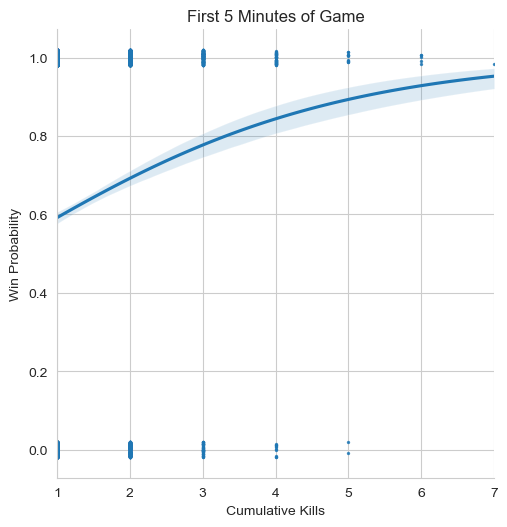

In [69]:
df_kills_min_x = df_kills.copy(deep=True)
df_kills_min_x = df_kills_min_x[(df_kills_min_x['value']<=5)]
print(pd.unique(df_kills_min_x['action_count']))
print(len(pd.unique(df_kills_min_x['gameID'])))

sns.lmplot(x='action_count', y='win', data=df_kills_min_x, 
               y_jitter=.02, logistic=True, scatter_kws={'s':2})
plt.title('First 5 Minutes of Game')
plt.ylabel('Win Probability')
plt.xlabel('Cumulative Kills')
plt.show()

### Observation - Kills Within 5 Minutes
So if a team gets 5 kills within the first 5 minutes of the game, the likelihood of that team winning is roughly 85% based on kills alone.  This seems somewhat counter to the first plot suggesting a team with 5 kills within the first 2 minutes has a 70% likelihood of winning the game.  Interesting.  But I reason this by thinking it's more advantageous to level up in ways other than directly attacking your opponent at the start.  So many factors play into LOL and winning probability so I do not discredit these plots, but insightful.  We'll see how the final model plays out and the combination of features that best predict winning probability.

In [70]:
df_kills_min_x.head()

,gameID,variable,win_team,action_count,value,var_color,win,minute_bin
7,NALCS-c1678fe8c1106f56,bKills_min,blue,1,4.413,blue,True,"(0, 5]"
9,NALCS-bb82a23d050613d1,bKills_min,blue,1,3.652,blue,True,"(0, 5]"
13,NALCS-7a7bb445d18d9d78,bKills_min,red,1,3.853,blue,False,"(0, 5]"
14,NALCS-205d8eb5a6029a26,bKills_min,blue,1,2.601,blue,True,"(0, 5]"
22,NALCS-b8637cf4aa7edc70,bKills_min,red,1,3.092,blue,False,"(0, 5]"


In [71]:
lst_bins = list(pd.unique(df_kills_min_x['minute_bin'])[:5].sort_values())

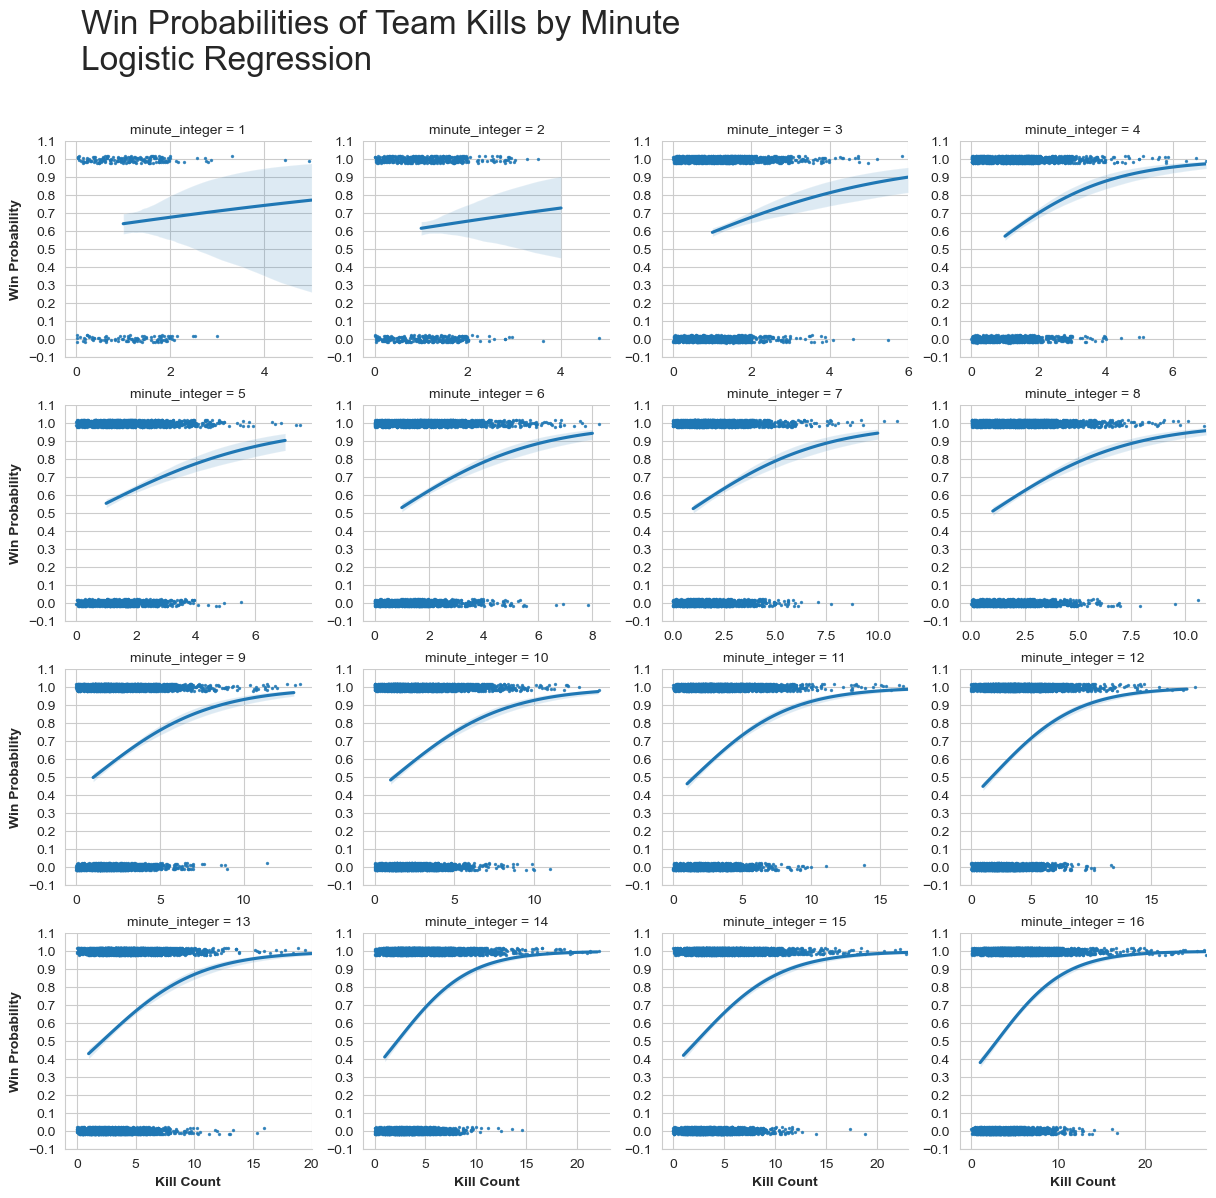

In [72]:
df_kills_min_x = df_kills.copy(deep=True)
df_kills_min_x['minute_integer'] = df_kills_min_x['value'].astype(int)
df_kills_min_x = df_kills_min_x[(df_kills_min_x['minute_integer']<=16)]

g = sns.lmplot(x='action_count', y='win', col='minute_integer', col_wrap = 4, data=df_kills_min_x, 
               x_jitter=True, y_jitter=.02, logistic=True, scatter_kws={'s':2}, size=3, aspect=1, sharex=False, sharey = False)
g.set_xlabels('Kill Count', fontweight='bold')
g.set_ylabels('Win Probability', fontweight='bold')
g.set(yticks=np.arange(-.1, 1.1, .1))
g.fig.suptitle('Win Probabilities of Team Kills by Minute\nLogistic Regression', horizontalalignment='left', x=0.05, fontsize=24)
g.fig.subplots_adjust(top=0.87)

## Towers (Turrets) Destroyer 
The data reformat process for towers data is very similar to kills.  So I'll skip a lot of the explanation needed to reformat this data and consolidate the process in one cell below.

In [73]:
# Timestamp values in towers data is unsorted.  First create new columns of sorted tower destruction times.
df['bTowers_sorted'] = df.bTowers.sort_values().apply(lambda x: sorted(x))
df['rTowers_sorted'] = df.rTowers.sort_values().apply(lambda x: sorted(x))

# Unstack bTowers_sorted and rTowers_sorted
df_towers = df[['bTowers_sorted', 'rTowers_sorted']].unstack().apply(pd.Series)
df_towers.head()

# Map Level 1 index to dct_index_gameID and dct_win_team
df_towers['gameID'] = (df_towers.index.get_level_values(1))
df_towers['gameID'] = df_towers['gameID'].map(dct_index_gameID)

df_towers['win_team'] = (df_towers.index.get_level_values(1))
df_towers['win_team'] = df_towers['gameID'].map(dct_gameID_win)

# Transform "variable" index to column
df_towers = df_towers.reset_index(level=0, drop=False)
df_towers = df_towers.rename(columns={'level_0':'variable'})

# Reformat dataframe to transform columns (tower number) to a single column with the minute value within it through pd.melt
melt_towers = pd.melt(df_towers, ['gameID', 'variable', 'win_team'], var_name='tower_count').fillna(0)

# Additional melt_towers columns
melt_towers['var_color'] = np.where(melt_towers['variable']=='bTowers_sorted', 'blue', 'red')

melt_towers['win'] = False
melt_towers.loc[((melt_towers['var_color']=='blue') & (melt_towers['win_team']=='blue')) | 
               ((melt_towers['var_color']=='red') & (melt_towers['win_team']=='red')), 'win'] = True

In [74]:
melt_towers['tower_count'] = melt_towers['tower_count'] + 1

In [75]:
melt_towers['value'] = [x[0] if isinstance(x, list) else x for x in melt_towers['value']]
melt_towers['minute_bin'] = pd.cut(melt_towers['value'], bins=np.arange(0,82,5))
melt_towers['minute_integer'] = melt_towers['value'].astype(int)
df_towers = melt_towers[melt_towers['minute_bin'].notnull()]

df_towers = df_towers.sort_values(by=['gameID', 'variable', 'value'])
df_towers.head(25)

,gameID,variable,win_team,tower_count,value,var_color,win,minute_bin,minute_integer
4237,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,1,15.192,blue,True,"(15, 20]",15
19477,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,2,18.847,blue,True,"(15, 20]",18
34717,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,3,21.504,blue,True,"(20, 25]",21
49957,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,4,22.918,blue,True,"(20, 25]",22
65197,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,5,22.942,blue,True,"(20, 25]",22
80437,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,6,23.165,blue,True,"(20, 25]",23
95677,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,7,23.362,blue,True,"(20, 25]",23
110917,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,8,26.291,blue,True,"(25, 30]",26
126157,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,9,29.590,blue,True,"(25, 30]",29
141397,CBLoL-02bb50cd9654cf5d,bTowers_sorted,blue,10,30.861,blue,True,"(30, 35]",30


In [76]:
# Quick check to make sure this all worked
# check_gameID = 'NA-055b17da8456fdc8'
check_gameID = 'NALCS-0ed1cd0e0e57329c'
df_towers[df_towers['gameID']==check_gameID]

,gameID,variable,win_team,tower_count,value,var_color,win,minute_bin,minute_integer
3,NALCS-0ed1cd0e0e57329c,bTowers_sorted,red,1,18.541,blue,False,"(15, 20]",18
15243,NALCS-0ed1cd0e0e57329c,bTowers_sorted,red,2,19.941,blue,False,"(15, 20]",19
30483,NALCS-0ed1cd0e0e57329c,bTowers_sorted,red,3,22.879,blue,False,"(20, 25]",22
45723,NALCS-0ed1cd0e0e57329c,bTowers_sorted,red,4,38.770,blue,False,"(35, 40]",38
7623,NALCS-0ed1cd0e0e57329c,rTowers_sorted,red,1,19.122,red,True,"(15, 20]",19
22863,NALCS-0ed1cd0e0e57329c,rTowers_sorted,red,2,20.760,red,True,"(20, 25]",20
38103,NALCS-0ed1cd0e0e57329c,rTowers_sorted,red,3,27.034,red,True,"(25, 30]",27
53343,NALCS-0ed1cd0e0e57329c,rTowers_sorted,red,4,29.969,red,True,"(25, 30]",29
68583,NALCS-0ed1cd0e0e57329c,rTowers_sorted,red,5,31.665,red,True,"(30, 35]",31
83823,NALCS-0ed1cd0e0e57329c,rTowers_sorted,red,6,36.384,red,True,"(35, 40]",36


In [77]:
print(df['bTowers'][df['gameID']==check_gameID])
print(df['rTowers'][df['gameID']==check_gameID])

3    [[19.941, BOT_LANE, OUTER_TURRET], [38.77, TOP...
Name: bTowers, dtype: object
3    [[36.384, MID_LANE, NEXUS_TURRET], [31.665, MI...
Name: rTowers, dtype: object


Looks good.  Let's take a look at Towers data from a KNN perspective, with visuzliations using value (minutes) and tower_count (towers_destroyed).

In [78]:
print(lst_gameID)

['NALCS-fbb300951ad8327c' 'NALCS-055b17da8456fdc8'
 'NALCS-8e8a9b58df366e2d' ... 'OPL-671b2487ca72bfab'
 'OPL-7cdb33f56fe49084' 'OPL-13203adbaa0c1fa5']


In [79]:
lst_gameID[3]

'NALCS-0ed1cd0e0e57329c'

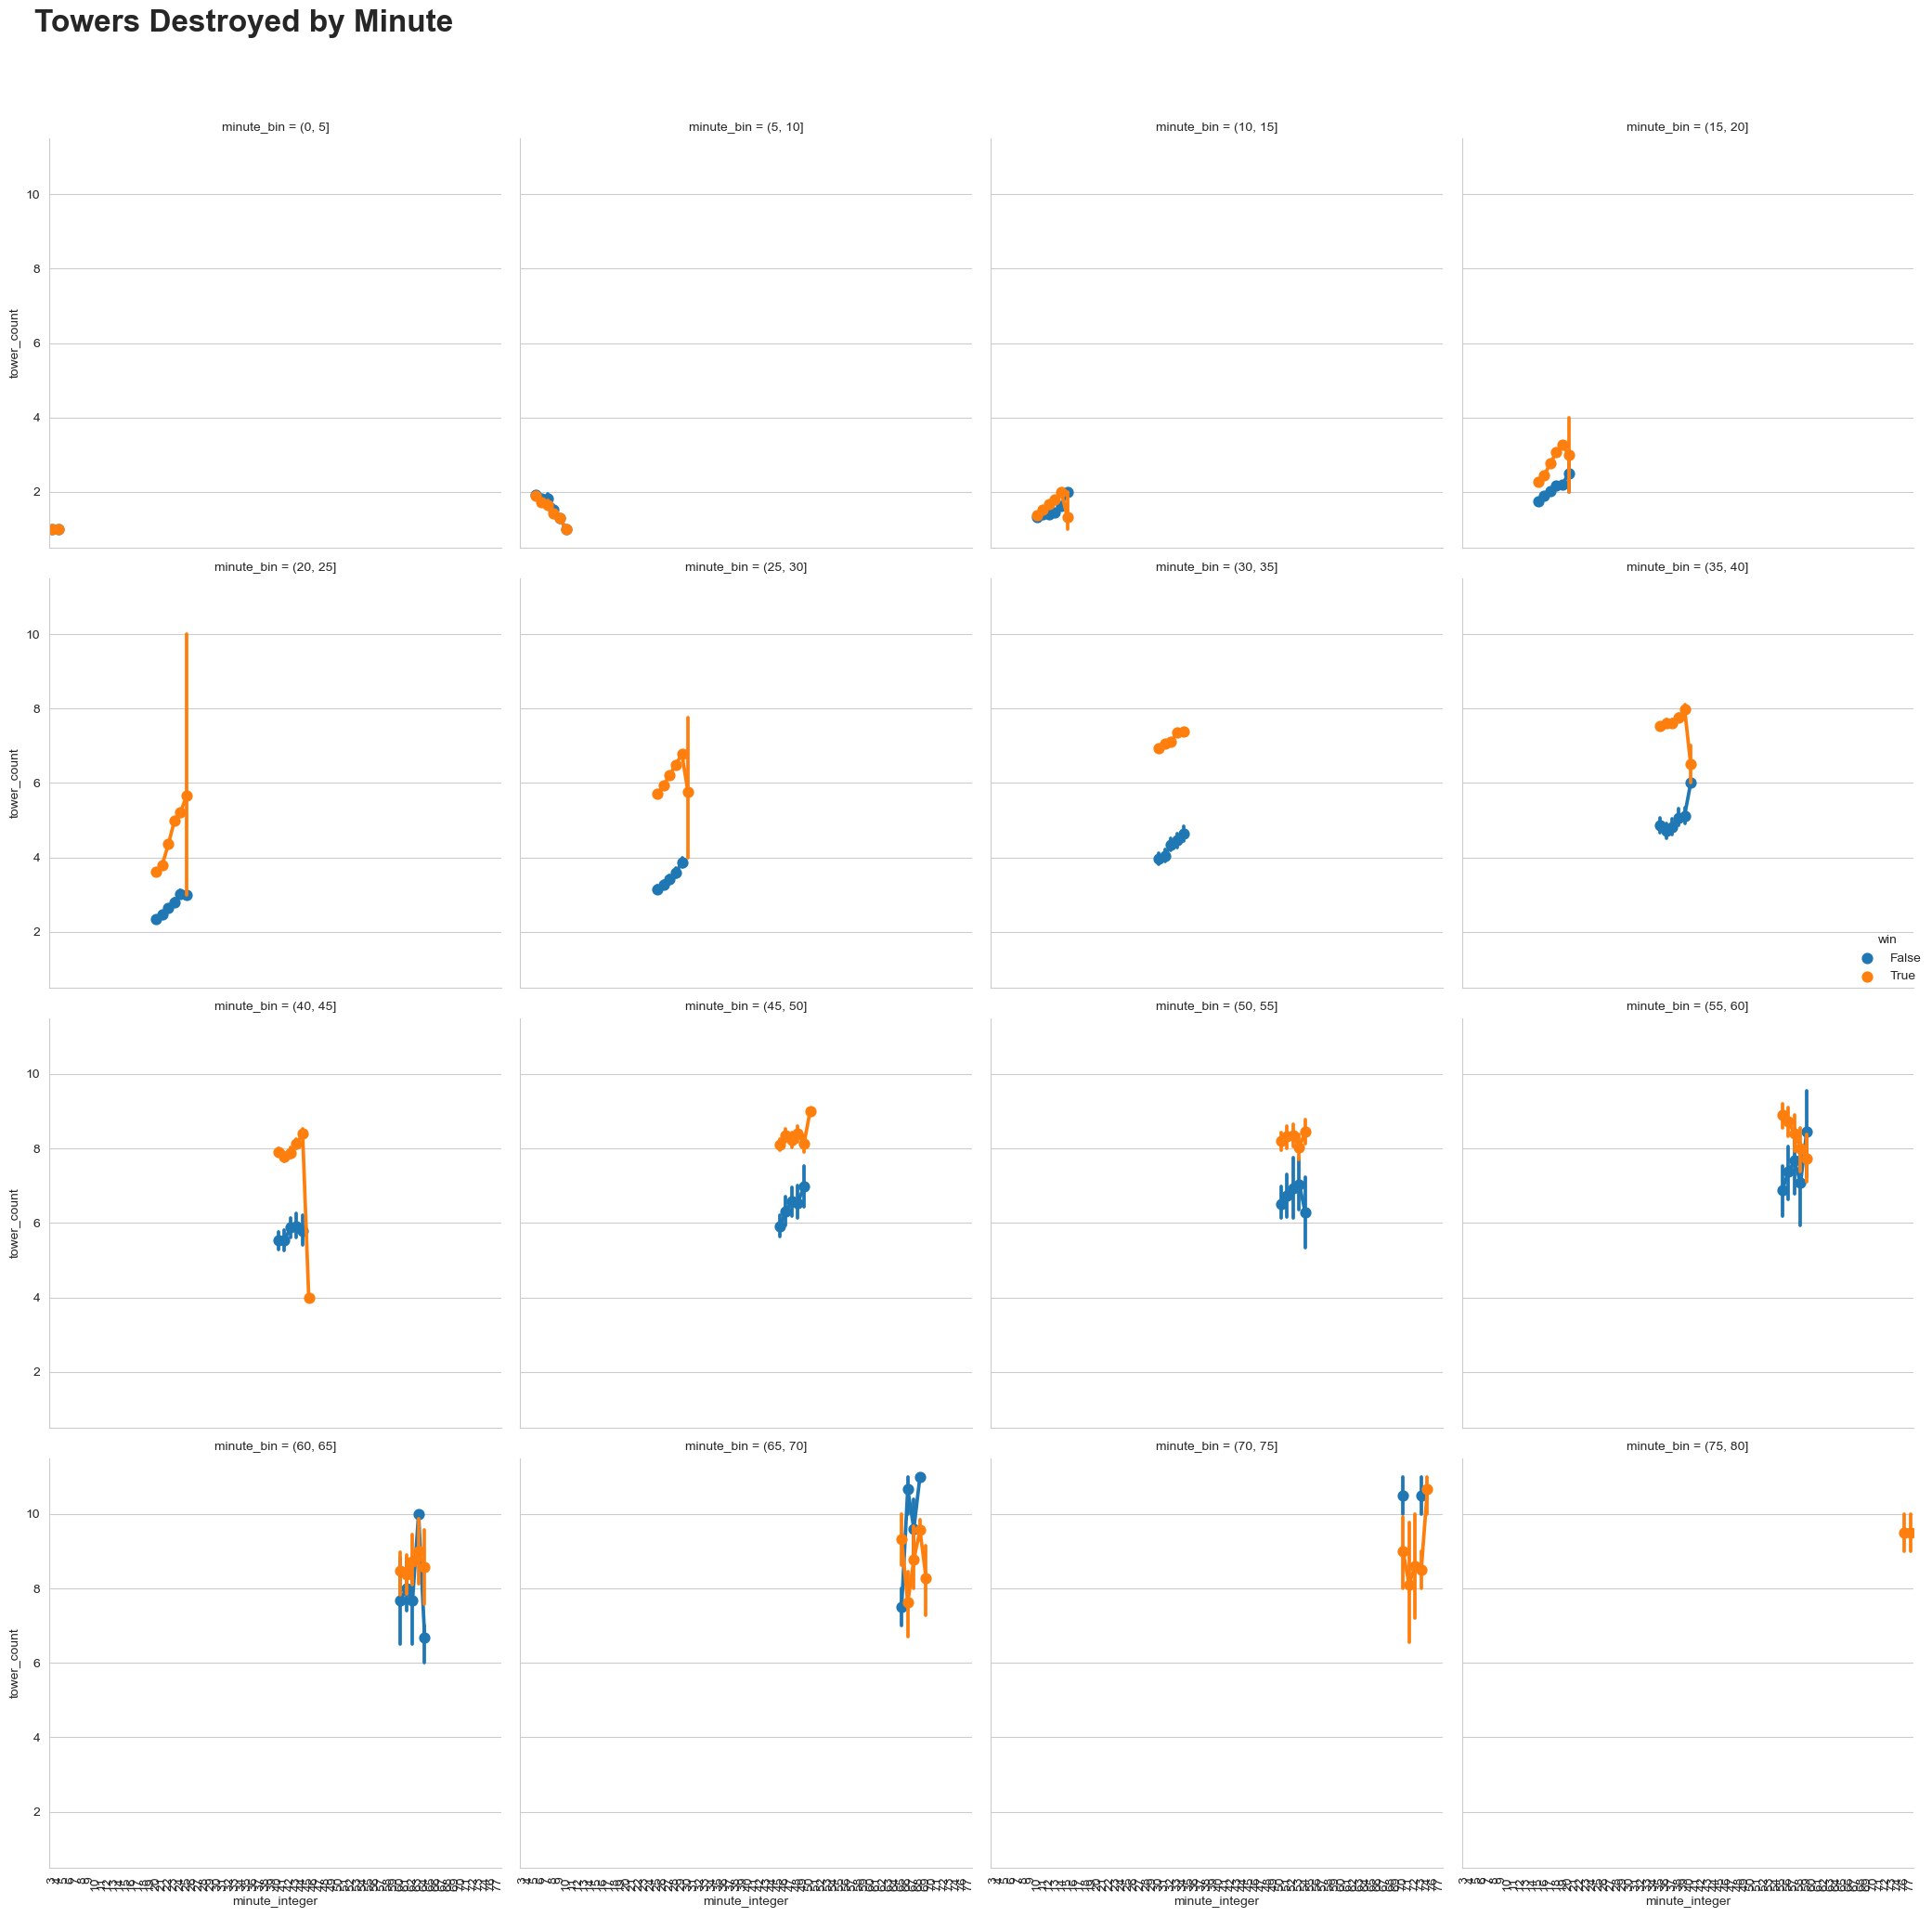

In [80]:
g = sns.factorplot(x='minute_integer', y='tower_count', hue='win', col='minute_bin', col_wrap = 4, 
                   data=df_towers)
g.set_xticklabels(rotation=90)
g.scatter_kws={'s':2}
g.fig.suptitle('Towers Destroyed by Minute', horizontalalignment='left', fontsize=24, fontweight='bold', x=0.02, y=1.03)
plt.tight_layout()

------------------------------------------------------------------------------------------------------------

<a id="section-three"></a>
## Modeling
After this analysis we will focus on these features.

Like Fuchs, we will analyze a subset of the available columns. The columns and their descriptions are provided. 

- `blueTeamTag` Blue Team's tag name (ex. Team SoloMid is TSM)
- `bResult` Result of the match for Blue Team 1 is a win, 0 is a loss 
- `goldblue`	Blue Team's total gold value by minute
- `bKills`	List of Blue Team's kills - [Time in minutes, Victim, Killer, Assist1, Assist2, Assist3, Assist4, x_pos, y_pos]
- `bTowers`	List of minutes that Blue Team destroyed a tower and Tower Location
- `bInhibs`	List of minutes that Blue Team destroyed an inhibitor and Location
- `bDragons`	List of minutes that Blue Team killed a dragon
- `bBarons`	List of minutes that Blue Team killed a baron
- `bHeralds`	List of minutes that Blue Team killed a rift herald 
- `redTeamTag` Red Team's tag name (ex. Cloud9 is C9)
- `bResult` Result of the match for Red Team 1 is a win, 0 is a loss 
- `goldblue`	Red Team's total gold value by minute
- `bKills`	List of Red Team's kills - [Time in minutes, Victim, Killer, Assist1, Assist2, Assist3, Assist4, x_pos, y_pos]
- `bTowers`	List of minutes that Red Team destroyed a tower and Tower location
- `bInhibs`	List of minutes that Red Team destroyed an inhibitor and location
- `bDragons`	List of minutes that Red Team killed a dragon
- `bBarons`	List of minutes that Red Team killed a baron
- `bHeralds`	List of minutes that Red Team killed a rift herald 

In [81]:
# dataframe information
df = df_raw.copy(deep=True)

## Preparing the Dataset

1. Turn psudolists into real lists.
2. Turn objects into more applicable data types. 

In [82]:
# Transform all the columns containing pseudo lists to real lists

df['goldblue'] = df['goldblue'].apply(literal_eval)
df['bKills'] = df['bKills'].apply(literal_eval)
df['bTowers'] = df['bTowers'].apply(literal_eval)
df['bInhibs'] = df['bInhibs'].apply(literal_eval)
df['bDragons'] = df['bDragons'].apply(literal_eval)
df['bBarons'] = df['bBarons'].apply(literal_eval)
df['bHeralds'] = df['bHeralds'].apply(literal_eval)

df['goldred'] = df['goldred'].apply(literal_eval)
df['rKills'] = df['rKills'].apply(literal_eval)
df['rTowers'] = df['rTowers'].apply(literal_eval)
df['rInhibs'] = df['rInhibs'].apply(literal_eval)
df['rDragons'] = df['rDragons'].apply(literal_eval)
df['rBarons'] = df['rBarons'].apply(literal_eval)
df['rHeralds'] = df['rHeralds'].apply(literal_eval)

In [83]:
df.head(5)
print(df['bKills'][1])
print(df['bTowers'][1])

[[11.104, 'DIG Shiphtur', 'CST Jesiz', ['CST Impaler'], 9294, 8716], [12.332, 'DIG Crumbzz', 'CST Cris', ['CST Sheep'], 9601, 5282], [12.392, 'DIG CoreJJ', 'CST Cris', ['CST Impaler', 'CST Mash'], 9967, 6811], [12.665, 'DIG Gamsu', 'CST Cris', ['CST Impaler', 'CST Mash', 'CST Sheep'], 10870, 5390], [14.837, 'DIG Crumbzz', 'CST Mash', ['CST Sheep'], 8556, 2686], [25.008, 'DIG KiWiKiD', 'CST Jesiz', ['CST Cris', 'CST Impaler', 'CST Mash', 'CST Sheep'], 9648, 6310], [25.134, 'DIG CoreJJ', 'CST Mash', ['CST Cris', 'CST Impaler', 'CST Jesiz', 'CST Sheep'], 9646, 6344], [28.412, 'DIG Crumbzz', 'CST Jesiz', ['CST Impaler', 'CST Mash', 'CST Sheep'], 8786, 8643], [30.128, 'DIG CoreJJ', 'CST Impaler', ['CST Cris', 'CST Mash'], 4790, 4742], [32.367, 'DIG KiWiKiD', 'CST Jesiz', ['CST Impaler', 'CST Sheep'], 10142, 7246]]
[[23.239, 'BOT_LANE', 'OUTER_TURRET'], [33.018, 'BOT_LANE', 'INNER_TURRET'], [28.989, 'BOT_LANE', 'FOUNTAIN_TURRET'], [25.564, 'MID_LANE', 'OUTER_TURRET'], [20.058, 'BOT_LANE', 'F

In [84]:
# Capturing only the information that interests us from the data lists

data = pd.DataFrame()

# Set cutoff
df = df[df.gamelength > 31]
cutoff_mins = 30

# only analyze the objectives that occured before 30 minutes
# can make a new dataframe (a series essentially), remove all the objectives captured after cutoff time

def objectives_before(column: pd.Series, length: float):
    '''Retrieves objectives obtained before a defined time, from the list of lists in dataset
    
    Parameters
    ----------
    column : pd.Series
        series containing the list of lists of lists of a particular objective
    length : float
        grab objectives from before this time
        
    Returns
    -------
    wanted_objs : list
        list of lists (games), with the 2nd level only containing the objectives before the desired time  
    
    '''
    
    column = column.to_list()
    wanted_objs = []
    for i, game in enumerate(column):
        #print("game: ", game)
        wanted_objs.append([])
        for obj in game: 
            #print("kill in game: ", kill)
            if obj[0] < length:
                wanted_objs[i].append(obj)
    #print(wanted_kills)
    
    #wanted_kills = [kill for kill in series_to_list if kill[0][0] < length]
    return wanted_objs


# apply function to list type columns to grab objectives before cutoff time
data = df.assign(blue_kills=lambda x: objectives_before(df['bKills'], cutoff_mins),
                red_kills=lambda x: objectives_before(df['rKills'], cutoff_mins),
                blue_towers=lambda x: objectives_before(df['bTowers'], cutoff_mins),
                red_towers=lambda x: objectives_before(df['rTowers'], cutoff_mins),
                blue_inhibs=lambda x: objectives_before(df['bInhibs'], cutoff_mins),
                red_inhibs=lambda x: objectives_before(df['rInhibs'], cutoff_mins),
                blue_dragons=lambda x: objectives_before(df['bDragons'], cutoff_mins),
                red_dragons=lambda x: objectives_before(df['rDragons'], cutoff_mins),
                blue_barons=lambda x: objectives_before(df['bBarons'], cutoff_mins),
                red_barons=lambda x: objectives_before(df['rBarons'], cutoff_mins),
                blue_heralds=lambda x: objectives_before(df['bHeralds'], cutoff_mins),
                red_heralds=lambda x: objectives_before(df['rHeralds'], cutoff_mins))


data['red_kills'] = data['red_kills'].apply(len)
data['red_towers'] = data['red_towers'].apply(len)
data['red_inhibs'] = data['red_inhibs'].apply(len)
data['red_dragons'] = data['red_dragons'].apply(len)
data['red_barons'] = data['red_barons'].apply(len)
data['red_heralds'] = data['red_heralds'].apply(len)

data['blue_kills'] = data['blue_kills'].apply(len)
data['blue_towers'] = data['blue_towers'].apply(len)
data['blue_inhibs'] = data['blue_inhibs'].apply(len)
data['blue_dragons'] = data['blue_dragons'].apply(len)
data['blue_barons'] = data['blue_barons'].apply(len)
data['blue_heralds'] = data['blue_heralds'].apply(len)

data['blue_tag'] = df['blueTeamTag']
data['blue_result'] = df['bResult']
data['blue_end_gold'] = df['goldblue'].apply(lambda x:x[cutoff_mins-1])
data['red_tag'] = df['redTeamTag']
data['red_result'] = df['rResult']
data['red_end_gold'] = df['goldred'].apply(lambda x:x[cutoff_mins-1])

# generate binary win column
data['winner'] = np.where(data['blue_result'] == 1, 1, 2)
print(data.columns)
display(data.head(5))
display(data[['blue_tag', 'blue_result','blue_kills', 'blue_towers', "blue_inhibs", "blue_dragons", 'blue_heralds',
              'red_tag', 'red_result','red_kills', 'red_towers', "red_inhibs", "red_dragons", 'red_heralds',
              'winner']])


Index(['League', 'Year', 'Season', 'Type', 'blueTeamTag', 'bResult', 'rResult',
       'redTeamTag', 'gamelength', 'golddiff', 'goldblue', 'bKills', 'bTowers',
       'bInhibs', 'bDragons', 'bBarons', 'bHeralds', 'goldred', 'rKills',
       'rTowers', 'rInhibs', 'rDragons', 'rBarons', 'rHeralds', 'blueTop',
       'blueTopChamp', 'goldblueTop', 'blueJungle', 'blueJungleChamp',
       'goldblueJungle', 'blueMiddle', 'blueMiddleChamp', 'goldblueMiddle',
       'blueADC', 'blueADCChamp', 'goldblueADC', 'blueSupport',
       'blueSupportChamp', 'goldblueSupport', 'blueBans', 'redTop',
       'redTopChamp', 'goldredTop', 'redJungle', 'redJungleChamp',
       'goldredJungle', 'redMiddle', 'redMiddleChamp', 'goldredMiddle',
       'redADC', 'redADCChamp', 'goldredADC', 'redSupport', 'redSupportChamp',
       'goldredSupport', 'redBans', 'Address', 'blue_kills', 'red_kills',
       'blue_towers', 'red_towers', 'blue_inhibs', 'red_inhibs',
       'blue_dragons', 'red_dragons', 'blue_barons', 'r

,League,Year,Season,Type,blueTeamTag,bResult,rResult,redTeamTag,gamelength,golddiff,...,red_barons,blue_heralds,red_heralds,blue_tag,blue_result,blue_end_gold,red_tag,red_result,red_end_gold,winner
0,NALCS,2015,Spring,Season,TSM,1,0,C9,40,"[0, 0, -14, -65, -268, -431, -488, -789, -494,...",...,1,0,0,TSM,1,45845,C9,0,41126,1
1,NALCS,2015,Spring,Season,CST,0,1,DIG,38,"[0, 0, -26, -18, 147, 237, -152, 18, 88, -242,...",...,0,0,0,CST,0,43767,DIG,1,41336,2
2,NALCS,2015,Spring,Season,WFX,1,0,GV,40,"[0, 0, 10, -60, 34, 37, 589, 1064, 1258, 913, ...",...,0,0,0,WFX,1,49255,GV,0,42208,1
3,NALCS,2015,Spring,Season,TIP,0,1,TL,41,"[0, 0, -15, 25, 228, -6, -243, 175, -346, 16, ...",...,0,0,0,TIP,0,41672,TL,1,42829,2
4,NALCS,2015,Spring,Season,CLG,1,0,T8,35,"[40, 40, 44, -36, 113, 158, -121, -191, 23, 20...",...,0,0,0,CLG,1,46935,T8,0,41814,1


,blue_tag,blue_result,blue_kills,blue_towers,blue_inhibs,blue_dragons,blue_heralds,red_tag,red_result,red_kills,red_towers,red_inhibs,red_dragons,red_heralds,winner
0,TSM,1,9,6,1,0,0,C9,0,5,3,0,2,0,1
1,CST,0,8,5,0,2,0,DIG,1,7,5,0,1,0,2
2,WFX,1,15,6,0,2,0,GV,0,7,1,0,0,0,1
3,TIP,0,7,3,0,0,0,TL,1,13,4,0,3,0,2
4,CLG,1,14,4,0,1,0,T8,0,9,3,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7614,AUR,0,3,0,0,0,1,RBE,1,7,3,0,3,0,2
7615,YC,0,7,4,0,0,0,SUP,1,12,5,0,3,0,2
7616,GAL,0,7,4,0,2,0,DP,1,12,6,0,1,1,2
7618,LGC,1,10,6,0,3,0,TTC,0,2,2,0,0,0,1


In [85]:
# quick test
assert(set(['blue_end_gold','blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
                  'red_end_gold','red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds', 'winner']).issubset(data.columns))

<a id="section-four"></a>
## Explore the Dataset

The objectives we will analyze are described below. These objectives are typically sought after and help the team toward their goal of destorying their enemy's nexus. These objectives are:

- **Gold**: Gold can be earned by killing players, monsters, minions, and constructs. Certain items or champions provide increased Gold earnings. A small amount of Gold is also placed into every players' inventory every second.
- **Player kills**: Killing enemy players provides Gold in addition to disabling the enemy player until they respawn. Depending on the game version, killing players with many kills earns more Gold, and killing players with many deaths provides less Gold.
- **Tower kills**: Towers defend the lanes and base of each team. Towers deal major damage to enemy creeps and players. Two of the Eleven Towers are referred to as the inner towers and specifically defend the nexus.
- **Inhibitor kills**: Three Inhibitors are found in each base. Destroying an enemy inhibitor temporarily empowers your minions before the inhibitor repairs itself and must be destroyed again. Importantly, your nexus cannot be destroyed while a friendly inhibitor stands.
- **Dragon kills**: The Dragon is a powerful monster on the map. The Dragon can be killed to provide a large amount of gold and various buffs to your team. The Dragon respawns regularly and may provide a different buff each time.  
- **Baron kills**: The Baron is the most powerful monster on the map, and is more difficult to kill than dragon. Killing Baron provides your team one of the strongest buffs in the game, and additionally allows you to empower friendly minions as they siege the enemy nexus.
- **Herald kills**: The Rift Herald spawns only twice and only early in the game. Killing the Rift Herald allows you to summon the Rift Herald, who then inflicts major damage to an enemy structure. The Rift Herald can only be found on the map until 19:45 gametime, after which Baron takes her place.

We will analyze these objectives as possible predictors for winning or losing the game. 

<AxesSubplot:>

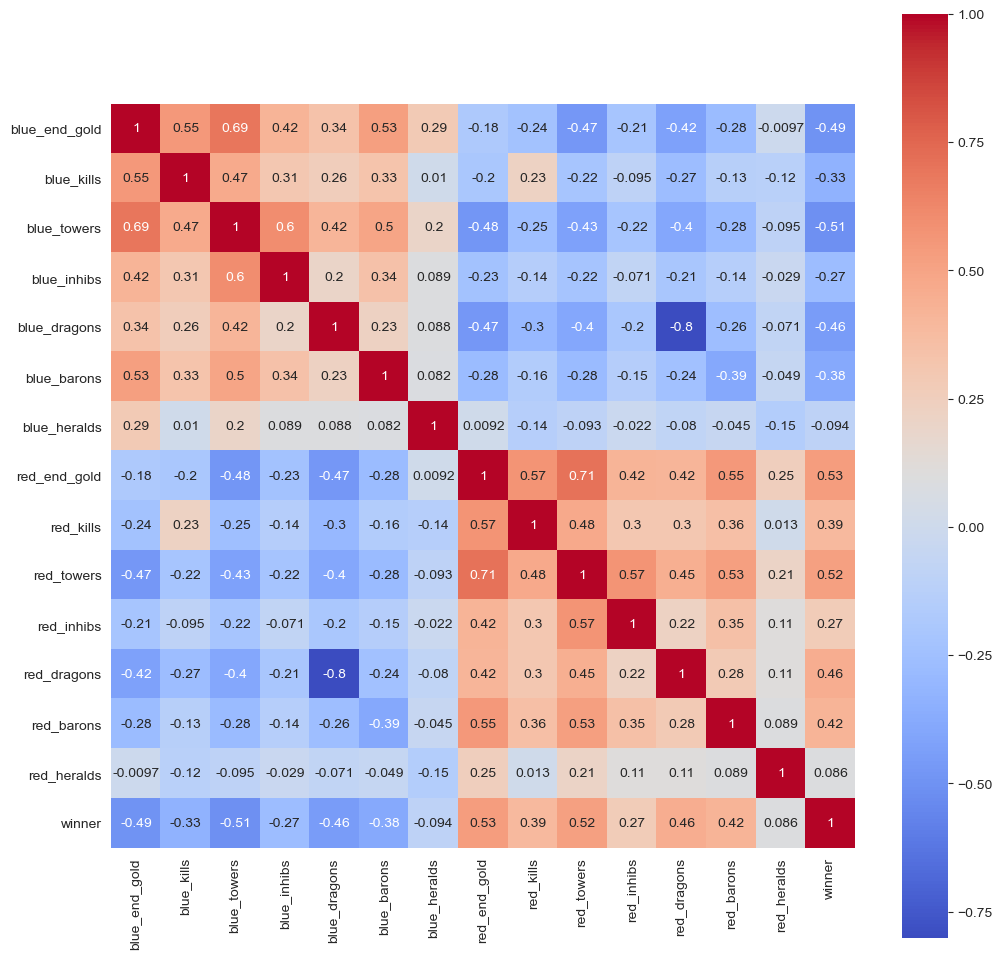

In [86]:
fig = plt.figure(figsize=(12,12))

sns.set_style('darkgrid')
sns.heatmap(data[['blue_end_gold','blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds', 'red_end_gold','red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds', 'winner']].corr(), annot=True, square=True, cmap='coolwarm')

From this heat map, we can average across blue and red teams. We find that the correlations between each objective and winning are:

- Towers Destroyed: ~0.52 (Moderate Correlation)
- Gold Earned: ~.50 (Moderate Correlation)
- Dragons Killed: 0.46 (Moderate Correlation)
- Barons Killed: 0.40 (Moderate Correlation)
- Kills: ~0.36 (Weak Correlation)
- Inhibitors Destroyed: 0.27 (Weak Correlation)
- Heralds Killed: 0.09 (Weak Correlation)


## Compute VIF: Assess Multicollinearity 
Blue and red dragons feature a notably high correlation. Let's compute the variance inflation factor between our predictor variables, and assess multicollinearity before training our models. 

In [87]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# find design matrix for regression model using 'winner' as response variable 
y, X = dmatrices('winner ~ blue_end_gold+blue_kills+blue_towers+blue_inhibs+blue_dragons+blue_barons+blue_heralds+red_end_gold+red_kills+red_towers+red_inhibs+red_dragons+red_barons+red_heralds', data=data[['blue_end_gold','blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
          'red_end_gold','red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds', 'winner']], return_type='dataframe')

# calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

# view VIF for each explanatory variable 
display(vif)

,VIF,variable
0,555.349716,Intercept
1,5.976842,blue_end_gold
2,2.665811,blue_kills
3,3.981469,blue_towers
4,1.615000,blue_inhibs
5,3.128605,blue_dragons
6,1.658492,blue_barons
7,1.210424,blue_heralds
8,6.382918,red_end_gold
9,2.790484,red_kills


We find that red and blue dragons slain do not have high VIF. However, We find that blue team gold and red team gold at the 30 minute mark to have high VIF:

- Blue Team Gold VIF = 5.98
- Red Team Gold VIF = 6.38

This makes sense given that team gold increases when taking any of the other objectives, both teams passively earn gold at an equal rate, and there are only a few other sources of team gold that are not accounted for here. To reduce the possibility of multicollinearity between our predictors, we'll drop `blue_end_gold` and `red_end_gold` before training our model. 

<a id="section-five"></a>
# Train Classification Models

## Split the Data

We want to split our data into a set that we train the model on and a set we test the model with. Using Scikit-learn, we can split our data so that we train on the majority (66.6%) and test the rest (33.3%) to see how we do.


In [88]:
# X = data[['blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
#           'red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds']]
X = data[['blue_kills', 'blue_towers', 'blue_inhibs', 'blue_dragons', 'blue_barons', 'blue_heralds',
          'red_kills','red_towers','red_inhibs', 'red_dragons', 'red_barons', 'red_heralds']]
y = data['winner']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## 1. Logistic Regression Model using scikit-learn

## Implement Logistic Regression Model

Fit logistic regression model to our training data.


In [89]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

logmodel = LogisticRegression(max_iter=1000)
logmodel.fit(X_train, y_train)

predictions = logmodel.predict(X_test)
weight = logmodel.coef_  
print(weight)

[[-0.15141798 -0.29079445 -0.009509   -0.3903509  -0.46768111  0.03711575
   0.16988411  0.30468924  0.02484167  0.13186208  0.68343501 -0.11014573]]


## Evaluate the Model

Evaluate model on test data.

Classification Report : 
               precision    recall  f1-score   support

           1       0.82      0.84      0.83       976
           2       0.82      0.79      0.81       880

    accuracy                           0.82      1856
   macro avg       0.82      0.82      0.82      1856
weighted avg       0.82      0.82      0.82      1856

Accuracy of Logistic Regression: 81.95%


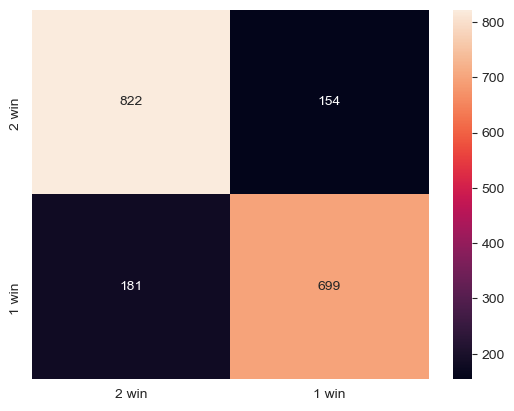

In [90]:
cr = classification_report(y_test, predictions)
print('Classification Report : \n', cr)

acc = round(logmodel.score(X_test, y_test) * 100, 2)
print("Accuracy of Logistic Regression: " + str(acc) + "%")

cm = confusion_matrix(y_test,predictions)
sns.heatmap(cm, annot=True, fmt="d", xticklabels=['2 win', '1 win'], yticklabels=['2 win', '1 win'],);

Model has a 81.95% accuracy when classifying unseen data.

## Testing the Predictor

Let's predict the winner for the 1st game in the `data` dataset. **Winterfox (WFX, Red team)** wins, defeating **Team Dignitas (DIG, Blue team)** in a 40 minute game, let's predict the winner based on the objectives taken in the first 30 minutes.  

In [91]:
# Predict the TSM x C9 match
X_case = X_train.loc[[16]]
y_case = y_train.loc[[16]]

pred = logmodel.predict_proba(X_case).reshape(-1,1)

win = round(logmodel.predict(X_case)[0], 2)
print("Winner is :", win)

fir_prob = round(pred[0][0] * 100, 2)
sec_prob = round(pred[1][0] * 100, 2) 
print("First team (blue) win probability is: " + str(fir_prob) + "%")
print("Second team (red) win probability is: " + str(sec_prob) + "%")

Winner is : 2
First team (blue) win probability is: 4.19%
Second team (red) win probability is: 95.81%


The model computes a 95.81% probability for Red team to win the game, accurately predicting the Red team Winterfox's win.

## 2. Use case of the model in analyzing the relationship between goals taken before 30 minutes and winning a game.

## Prepare the Data
Logistic regression in statsmodels requires an output between 0 and 1.

In [92]:
# winner = 1, when red wins. winner = 0, when blue wins
y_train = y_train-1
y_test = y_test-1

## Implement Logistic Regression Model
Fit logistic regression model to the training data and review results. View coefficients and compute 95% confidence interval for the odds-ratio for each predictor.  

In [93]:
# fit model to training data
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()

print(result.summary())
#print(result.params)
#print(result.conf_int())

# prepare coefficients and confidence intervals
ci = result.conf_int()
ci.rename(columns={0: 'lower', 1: 'upper'}, inplace=True)
coeffs = ci.assign(coefficients=result.params.values)

# compute odds ratios
coeffs["odds"] = math.e**coeffs["coefficients"]
coeffs["odds_lower"] = math.e**coeffs["lower"]
coeffs["odds_upper"] = math.e**coeffs["upper"]

display(coeffs)

Optimization terminated successfully.
         Current function value: 0.396501
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                 winner   No. Observations:                 3766
Model:                          Logit   Df Residuals:                     3754
Method:                           MLE   Df Model:                           11
Date:                Mon, 27 Feb 2023   Pseudo R-squ.:                  0.4268
Time:                        16:50:04   Log-Likelihood:                -1493.2
converged:                       True   LL-Null:                       -2605.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
blue_kills      -0.1510      0.015    -10.249      0.000      -0.180      -0.122
blue_towers     -0.2881

,lower,upper,coefficients,odds,odds_lower,odds_upper
blue_kills,-0.179844,-0.122102,-0.150973,0.859871,0.835400,0.885058
blue_towers,-0.356973,-0.219233,-0.288103,0.749684,0.699791,0.803135
blue_inhibs,-0.348833,0.319955,-0.014439,0.985665,0.705511,1.377065
blue_dragons,-0.492515,-0.273705,-0.383110,0.681738,0.611087,0.760556
blue_barons,-0.703833,-0.241710,-0.472772,0.623272,0.494686,0.785284
blue_heralds,-0.142528,0.220030,0.038751,1.039512,0.867163,1.246114
red_kills,0.142217,0.198070,0.170144,1.185475,1.152827,1.219048
red_towers,0.237455,0.376265,0.306860,1.359151,1.268018,1.456833
red_inhibs,-0.356426,0.393191,0.018382,1.018552,0.700174,1.481701
red_dragons,0.033894,0.246066,0.139980,1.150251,1.034475,1.278983


Text(0.5, 1.0, 'Odds-Ratios for Red Team to Win')

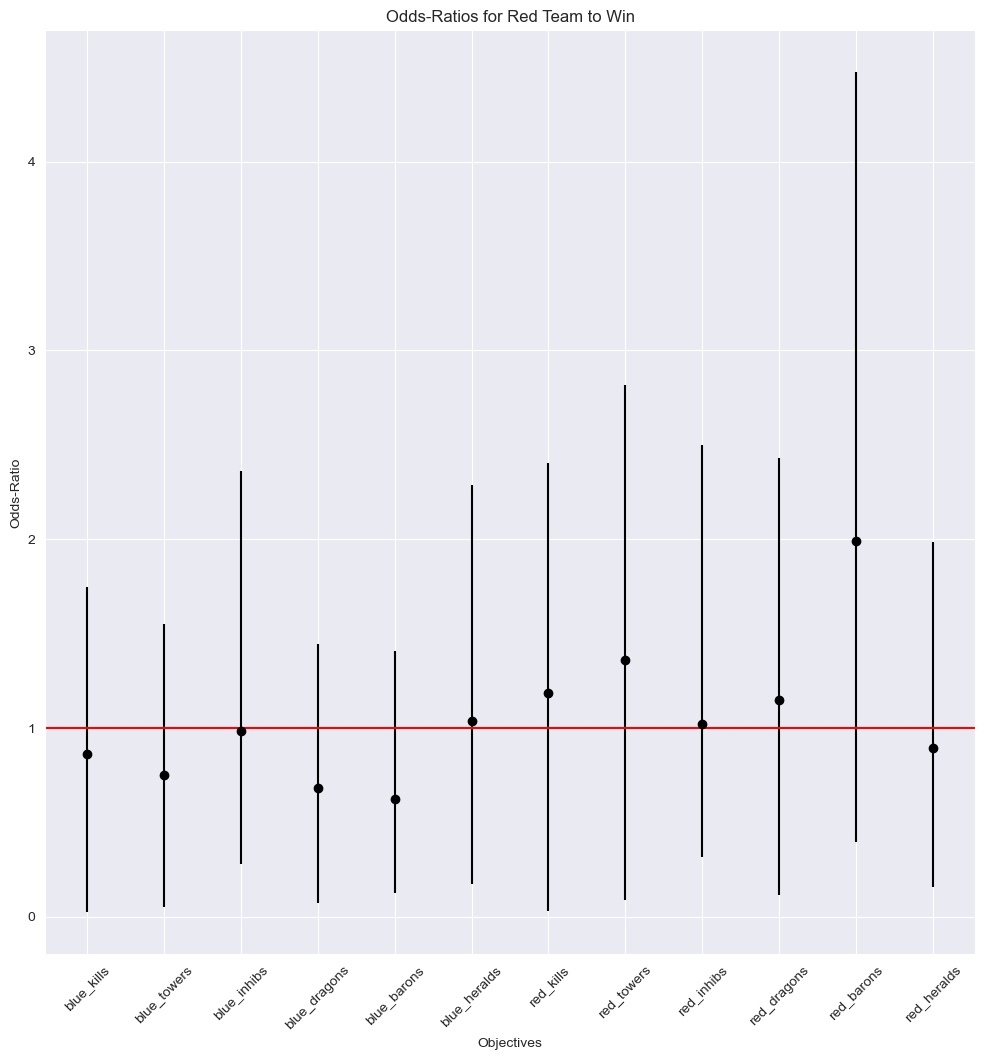

In [94]:
fig = plt.figure(figsize=(12,12))
                 
y = coeffs['odds']
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
#ticks = [tick-1 for tick in x]
errors = [coeffs['odds_lower'], coeffs['odds_upper']]
plt.errorbar(x, y, yerr=errors, fmt='ok')
plt.axhline(y=1, color='r', linestyle='-')
plt.xticks(x, list(coeffs.index), rotation=45)
plt.ylabel("Odds-Ratio")
plt.xlabel("Objectives")
plt.title("Odds-Ratios for Red Team to Win")

The logistic regression was used to analyze the relationship between objectives taken before 30 minutes and winning a game. The results are described in the above table. Odds-ratios with a 95% confidence interval for all predictors are computed. 

Let's envision ourselves as the *red team* to describe how objectives taken or given up before 30 minutes impact the odds of winning a game. The results of the logistic regression show the following significant relationships between a given predictor and winning the game, holding all other predictors constant:
- For each player kill, the odds of winning are expected to increase by 18% (95% CI [15%, 22%]).
- For each tower destroyed, the odds of winning are expected to increase by **35%** (95% CI [26%, 46%]).
- For each dragon killed, the odds of winning are expected to increase by 15% (95% CI [3%, 28%]).
- For each baron killed, the odds of winning are expected to increase by **99%** (95% CI [60%, 148%]).

Considering objectives given up to the enemy team:
- For each kill given up to the enemy team, the odds of winning are expected to decrease by 14% (95% CI [11%, 16%]).
- For each tower lost, the odds of winning are expected to decrease by 25% (95% CI [20%, 30%]).
- For each dragon taken by the enemy team, the odds of winning are expected to decrease by **32%** (95% CI [24%, 39%]).
- For each baron taken by the enemy team, the odds of winning are expected to decrease by **38%** (95% CI [21%, 50%]).

<a id="section-six"></a>
## Discussion

**Goal**. In this analysis, we aimed to determine the major factors which lead to winning or losing a League of Legends game, and attempt to predict the winner of a game based on objectives taken or given up before 30 minutes. 

**Models**. We were able to train a logistic regression model to predict the winner of competitive League of Legends games based on the objectives taken or given up before 30 minutes. We trained two models, one utilizing statsmodels and one utilizing scikit-learn. Despite only accessing the first 30 minutes of gameplay, both models were able to predict the future winner to ~80% accuracy. 

**Applications**. These models such as the ones developed here could be utilized by Riot while broadcasting competitive League of Legends games to present informative predictions of the winner of a match as the match progresses in real time. Additionally, amateur players are allowed to use 3rd-party applications while playing League of Legends matches. Building these models into a 3rd-party application could inform players of their odds of winning their current game, allowing them to make a more informed decision to either fight on or surrender early. These 3rd-party applications could also  describe the impact of map objectives on their odds of winning the game, in order to help a team decide their next moves.

**Findings**. The correlation heatmap suggests winning is moderately correlated betweeen towers taken, gold earned, and dragons and barons killed. The odds-ratios computed from the logistic regression model suggest players killed, towers destroyed, barons killed and dragons killed increase the odds of winning the game. Corroborating these findings, it is clear that towers destroyed, baron kills, dragon kills are highly impactful objectives to secure before 30 minutes. These results could inform efficient decision-making during a game. For example, a team could more effectively increase their odds of winning by choosing to slay a Dragon rather than a Herald, or by preparing to kill Baron rather than chasing a singular enemy player kill. 

## Conclusions

We draw a few notable conclusions:

- Baron and dragon kills are highly impactful objectives to secure before 30 minutes to increase odds of winning the game. These map monsters could be prioritized over towers or champion kills (i.e. thirsting) to more efficiently improve a team's odds of winning.
- Securing an objective as the red team and denying that objective to the enemy blue team have different impacts on the winning. This could be due to slight differences the position of objectives on the map, relative to the red and blue bases. For example, Baron spawns on the blue side of the river (the map's midline), making it more difficult for the red team to secure. This could explain why red team taking Baron leads to a greater increase in winning odds than blue team taking Baron. This is corroborated by the opposite position of Dragon and opposite relative impact on odds when slaying Dragon. 
- The current models predict based on objective counts with no information about the time objectives were taken. However, certain objectives may be meaningful at different time-points throughout the game, possibly due to game-mechanics such as first-blood gold or (in future patches) turret plating awards. Computing the correlation between objectives and win outcome across time could offer useful insights towards how the impact of an objective changes from early, mid, to late game. Additionally, the time course of captured objectives could be better analyzed using a long short-term memory network, possibly leading to more accurate predictions of match outcomes. 

### Ramp test

In [95]:
!ramp-test --submission starting_kit

Testing predicting-league-of-legends-winner
Reading train and test files from ./data/ ...
Reading cv ...
Training submissions\starting_kit ...
CV fold 0
	score  accuracy_score      time
	train          0.8243  0.124999
	valid          0.8022  0.001001
	test           0.8098  0.000000
CV fold 1
	score  accuracy_score   time
	train          0.8193  0.060
	valid          0.8189  0.000
	test           0.8080  0.001
CV fold 2
	score  accuracy_score      time
	train          0.8182  0.065999
	valid          0.8211  0.000000
	test           0.8080  0.000000
CV fold 3
	score  accuracy_score   time
	train          0.8218  0.062
	valid          0.8078  0.000
	test           0.8080  0.001
CV fold 4
	score  accuracy_score   time
	train          0.8165  0.047
	valid          0.8278  0.000
	test           0.8080  0.000
----------------------------
Mean CV scores
----------------------------
	score    accuracy_score        time
	train    0.82 ± 0.00274  0.1 ± 0.03
	valid  0.8156 ± 0.00927   0.0 ± 0.0